# RL Assignment 2 - Part 3: Double DQN

In [1]:
# Install the necessary packages

!pip install numpy matplotlib
!pip install gymnasium[classic-control]
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: matlabengineforpython R2021b has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of matlabengineforpython or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: matlabengineforpython R2021b has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of matlabengineforpython or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Defaulting to user installation because normal site-packages is not writeable
  Using cached gast-0.4.0-py3-none

Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
DEPRECATION: matlabengineforpython R2021b has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of matlabengineforpython or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beniget 0.4.1 requires gast~=0.5.0, but you have gast 0.4.0 which is incompatible.
pythran 0.10.0 requires gast~=0.5.0, but you have gast 0.4.0 which is incompatible.


In [5]:
# Import required libraries
import os
import random
import gymnasium
from gymnasium import spaces
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque
from IPython import display
from enum import Enum
import math
import glob
import pickle

%matplotlib inline

In [15]:
"""
Definition the DDQNAgent class based on the DeepMind's paper
Human-level control through deep reinforcement learning

Reference: https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf
"""
class DDQNAgent:
    def __init__(self, env, update_target_freq=50,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=None,
                 gamma=0.99, learning_rate=0.001, 
                 batch_size=32, memory_size=100000):
        self.env = env
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n

        # init replay buffer
        self.replay_buffer = deque(maxlen=memory_size)

        # init hyperparameters
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.update_target_freq = update_target_freq

        self._episodes_completed = 0

        # init the deep Q network
        # clone the Q network to get the target network
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self._update_target_model()

    def _build_model(self):
        """
        Build the deep Q network model
        
        Args:
            state_size: the size of the state space
            action_size: the size of the action space

        Returns:
            model: the deep Q network model
        """
        model = keras.Sequential(
            [
                layers.Dense(128, activation="relu", input_shape=(self.state_size,)),
                layers.Dense(256, activation="relu"),
                layers.Dense(128, activation="relu"),
                layers.Dense(self.action_size, activation="linear"),
            ]
        )
        return model

    def _update_target_model(self):
        """
        Update the target model with the weights of the main model
        """
        self.target_model.set_weights(self.model.get_weights())

    def choose_action(self, state):
        """
        Choose an action based on the epsilon-greedy policy
        
        Args:
            state: the current state of the environment
            
        Returns:
            action: the action to take
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)
        q_values = self.model(np.expand_dims(state, axis=0))
        return np.argmax(q_values.numpy()[0])

    def experience_replay(self):
        """
        Experience replay to train the deep Q network using Double DQN approach
        """
        if len(self.replay_buffer) < self.batch_size:
            return

        minibatch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = map(np.stack, zip(*minibatch))

        selected_actions = np.argmax(self.model.predict_on_batch(next_states), axis=1)
        next_q_values = self.target_model.predict_on_batch(next_states)
        selected_action_q_values = next_q_values[np.arange(self.batch_size), selected_actions]
        target_q_values = rewards + (self.gamma * selected_action_q_values * (1 - dones))

        with tf.GradientTape() as tape:
            q_values = self.model(states, training=True)
            action_masks = tf.one_hot(actions, self.action_size)
            masked_q_values = tf.reduce_sum(action_masks * q_values, axis=1)
            loss = tf.keras.losses.mean_squared_error(target_q_values, masked_q_values)

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))


    def save_weights(self, path):
        """
        Save the weights of the deep Q network model
        """
        self.model.save_weights(path)

    def load_weights(self, path):
        """
        Load the weights of the deep Q network model
        """
        self.model.load_weights(path)
        self._update_target_model()

    def _save_best_weights(self, path, episode, best_reward):
        """
        Save the best weights of the deep Q network model
        """
        if best_reward >= self._best_episode_reward:
            self.save_weights(path + f"_{episode + 1}_{best_reward}.weights.h5")

    def train(self, num_episodes=1000, early_stopping=True, reward_threshold=float("inf"), reward_override=False):
        total_steps = 0

        reward_history = []
        epsilon_history = []

        # epsilon_decay = (final_epsoilon / initial_epsilon) ** (1 / num_episodes)
        if self.epsilon_decay is None:
            self.epsilon_decay = (self.epsilon_min / self.epsilon) ** (1 / (num_episodes / 4))

        for episode in range(num_episodes):
            state, info = self.env.reset()
            terminated = False
            truncated = False
            episode_reward = 0

            while not (terminated or truncated):
                action = self.choose_action(state)
                next_state, reward, terminated, truncated, info = self.env.step(action)
                if reward_override:
                    # piazza suggested custom reward
                    tuned_reward = 100*((math.sin(3*next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) -\
                                  (math.sin(3*state[0]) * 0.0025 + 0.5 * state[1] * state[1]))
                    self.replay_buffer.append((state, action, tuned_reward, next_state, (terminated or truncated)))
                else:
                    self.replay_buffer.append((state, action, reward, next_state, (terminated or truncated)))

                    
                if total_steps % 5 == 0:
                    self.experience_replay()
                    
                if total_steps > 1000 and total_steps % self.update_target_freq == 0:
                    self._update_target_model()

                state = next_state
                episode_reward += reward
                total_steps += 1

            self._episodes_completed += 1
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            
            reward_history.append(episode_reward)
            epsilon_history.append(self.epsilon)

            # early stopping
            if len(reward_history)>100 and early_stopping:
                if np.mean(reward_history[-100:]) >= reward_threshold:
                    print(f"Early stopping at episode {episode + 1}")
                    break

            if reward_override:
                print(f"Episode: {episode + 1}, Reward: {episode_reward:.2f}, Epsilon: {self.epsilon:.2f}, XPos: {state[0]:.2f}, Running Mean Reward: {np.mean(reward_history[-100:]):.2f}")
            else:
                print(f"Episode: {episode + 1}, Reward: {episode_reward:.2f}, Epsilon: {self.epsilon:.2f}, Steps: {total_steps}, Running Mean Reward: {np.mean(reward_history[-100:]):.2f}")

        return reward_history, epsilon_history
    
    def evaluate(self, num_episodes=5, render=True):
        reward_history = []
        if render:
            img = plt.imshow(self.env.render())

        for episode in range(num_episodes):
            if render:
                img.set_data(self.env.render())
                display.display(plt.gcf())
                display.clear_output(wait=True)
            state, info = self.env.reset()
            terminated = False
            truncated = False
            episode_reward = 0

            while not (terminated or truncated):
                q_values = self.model(np.expand_dims(state, axis=0))
                action = np.argmax(q_values.numpy()[0])
                next_state, reward, terminated, truncated, info = self.env.step(action)

                state = next_state
                episode_reward += reward

            reward_history.append(episode_reward)
            # print(f"Episode: {episode + 1}, Reward: {episode_reward:.2f}")

        return reward_history


# CartPole Environment

In [16]:
# load the CartPole environment
env = gymnasium.make("CartPole-v1", render_mode='rgb_array')

# init the DDQNAgent
agent = DDQNAgent(env, gamma=0.99, memory_size=80_000, batch_size=64, 
                 learning_rate=0.0001, update_target_freq=250, 
                 epsilon=0.9, epsilon_min=0.001)

In [6]:
# train the agent
dqn_cartpole_reward_history, dqn_cartpole_epsilon_history = agent.train(num_episodes=20_000, reward_threshold=470)

2024-04-04 17:38:23.948143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-04 17:38:24.142134: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x81459b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-04 17:38:24.142184: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA H100 PCIe, Compute Capability 9.0
2024-04-04 17:38:24.145668: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


Episode: 1, Reward: 18.00, Epsilon: 0.90, Steps: 18, Running Mean Reward: 18.00
Episode: 2, Reward: 31.00, Epsilon: 0.90, Steps: 49, Running Mean Reward: 24.50
Episode: 3, Reward: 13.00, Epsilon: 0.90, Steps: 62, Running Mean Reward: 20.67


2024-04-04 17:38:24.258376: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episode: 4, Reward: 16.00, Epsilon: 0.90, Steps: 78, Running Mean Reward: 19.50
Episode: 5, Reward: 9.00, Epsilon: 0.89, Steps: 87, Running Mean Reward: 17.40
Episode: 6, Reward: 19.00, Epsilon: 0.89, Steps: 106, Running Mean Reward: 17.67
Episode: 7, Reward: 24.00, Epsilon: 0.89, Steps: 130, Running Mean Reward: 18.57
Episode: 8, Reward: 18.00, Epsilon: 0.89, Steps: 148, Running Mean Reward: 18.50
Episode: 9, Reward: 11.00, Epsilon: 0.89, Steps: 159, Running Mean Reward: 17.67
Episode: 10, Reward: 12.00, Epsilon: 0.89, Steps: 171, Running Mean Reward: 17.10
Episode: 11, Reward: 16.00, Epsilon: 0.89, Steps: 187, Running Mean Reward: 17.00
Episode: 12, Reward: 13.00, Epsilon: 0.89, Steps: 200, Running Mean Reward: 16.67
Episode: 13, Reward: 13.00, Epsilon: 0.88, Steps: 213, Running Mean Reward: 16.38
Episode: 14, Reward: 19.00, Epsilon: 0.88, Steps: 232, Running Mean Reward: 16.57
Episode: 15, Reward: 13.00, Epsilon: 0.88, Steps: 245, Running Mean Reward: 16.33
Episode: 16, Reward: 26.0

Episode: 93, Reward: 17.00, Epsilon: 0.79, Steps: 1853, Running Mean Reward: 19.92
Episode: 94, Reward: 22.00, Epsilon: 0.79, Steps: 1875, Running Mean Reward: 19.95
Episode: 95, Reward: 56.00, Epsilon: 0.79, Steps: 1931, Running Mean Reward: 20.33
Episode: 96, Reward: 12.00, Epsilon: 0.79, Steps: 1943, Running Mean Reward: 20.24
Episode: 97, Reward: 21.00, Epsilon: 0.79, Steps: 1964, Running Mean Reward: 20.25
Episode: 98, Reward: 8.00, Epsilon: 0.79, Steps: 1972, Running Mean Reward: 20.12
Episode: 99, Reward: 9.00, Epsilon: 0.79, Steps: 1981, Running Mean Reward: 20.01
Episode: 100, Reward: 17.00, Epsilon: 0.79, Steps: 1998, Running Mean Reward: 19.98
Episode: 101, Reward: 26.00, Epsilon: 0.78, Steps: 2024, Running Mean Reward: 20.06
Episode: 102, Reward: 10.00, Epsilon: 0.78, Steps: 2034, Running Mean Reward: 19.85
Episode: 103, Reward: 29.00, Epsilon: 0.78, Steps: 2063, Running Mean Reward: 20.01
Episode: 104, Reward: 18.00, Epsilon: 0.78, Steps: 2081, Running Mean Reward: 20.03
E

Episode: 192, Reward: 26.00, Epsilon: 0.69, Steps: 3922, Running Mean Reward: 20.86
Episode: 193, Reward: 40.00, Epsilon: 0.69, Steps: 3962, Running Mean Reward: 21.09
Episode: 194, Reward: 32.00, Epsilon: 0.69, Steps: 3994, Running Mean Reward: 21.19
Episode: 195, Reward: 25.00, Epsilon: 0.69, Steps: 4019, Running Mean Reward: 20.88
Episode: 196, Reward: 43.00, Epsilon: 0.69, Steps: 4062, Running Mean Reward: 21.19
Episode: 197, Reward: 38.00, Epsilon: 0.69, Steps: 4100, Running Mean Reward: 21.36
Episode: 198, Reward: 11.00, Epsilon: 0.69, Steps: 4111, Running Mean Reward: 21.39
Episode: 199, Reward: 34.00, Epsilon: 0.69, Steps: 4145, Running Mean Reward: 21.64
Episode: 200, Reward: 33.00, Epsilon: 0.69, Steps: 4178, Running Mean Reward: 21.80
Episode: 201, Reward: 18.00, Epsilon: 0.68, Steps: 4196, Running Mean Reward: 21.72
Episode: 202, Reward: 33.00, Epsilon: 0.68, Steps: 4229, Running Mean Reward: 21.95
Episode: 203, Reward: 13.00, Epsilon: 0.68, Steps: 4242, Running Mean Reward

Episode: 290, Reward: 61.00, Epsilon: 0.61, Steps: 9203, Running Mean Reward: 53.28
Episode: 291, Reward: 18.00, Epsilon: 0.61, Steps: 9221, Running Mean Reward: 53.25
Episode: 292, Reward: 126.00, Epsilon: 0.60, Steps: 9347, Running Mean Reward: 54.25
Episode: 293, Reward: 66.00, Epsilon: 0.60, Steps: 9413, Running Mean Reward: 54.51
Episode: 294, Reward: 116.00, Epsilon: 0.60, Steps: 9529, Running Mean Reward: 55.35
Episode: 295, Reward: 98.00, Epsilon: 0.60, Steps: 9627, Running Mean Reward: 56.08
Episode: 296, Reward: 21.00, Epsilon: 0.60, Steps: 9648, Running Mean Reward: 55.86
Episode: 297, Reward: 114.00, Epsilon: 0.60, Steps: 9762, Running Mean Reward: 56.62
Episode: 298, Reward: 39.00, Epsilon: 0.60, Steps: 9801, Running Mean Reward: 56.90
Episode: 299, Reward: 54.00, Epsilon: 0.60, Steps: 9855, Running Mean Reward: 57.10
Episode: 300, Reward: 30.00, Epsilon: 0.60, Steps: 9885, Running Mean Reward: 57.07
Episode: 301, Reward: 67.00, Epsilon: 0.60, Steps: 9952, Running Mean Rew

Episode: 386, Reward: 161.00, Epsilon: 0.53, Steps: 19743, Running Mean Reward: 109.19
Episode: 387, Reward: 133.00, Epsilon: 0.53, Steps: 19876, Running Mean Reward: 108.93
Episode: 388, Reward: 183.00, Epsilon: 0.53, Steps: 20059, Running Mean Reward: 109.48
Episode: 389, Reward: 200.00, Epsilon: 0.53, Steps: 20259, Running Mean Reward: 111.17
Episode: 390, Reward: 21.00, Epsilon: 0.53, Steps: 20280, Running Mean Reward: 110.77
Episode: 391, Reward: 39.00, Epsilon: 0.53, Steps: 20319, Running Mean Reward: 110.98
Episode: 392, Reward: 157.00, Epsilon: 0.53, Steps: 20476, Running Mean Reward: 111.29
Episode: 393, Reward: 61.00, Epsilon: 0.53, Steps: 20537, Running Mean Reward: 111.24
Episode: 394, Reward: 204.00, Epsilon: 0.53, Steps: 20741, Running Mean Reward: 112.12
Episode: 395, Reward: 157.00, Epsilon: 0.53, Steps: 20898, Running Mean Reward: 112.71
Episode: 396, Reward: 297.00, Epsilon: 0.53, Steps: 21195, Running Mean Reward: 115.47
Episode: 397, Reward: 35.00, Epsilon: 0.52, St

Episode: 481, Reward: 328.00, Epsilon: 0.47, Steps: 34240, Running Mean Reward: 150.12
Episode: 482, Reward: 257.00, Epsilon: 0.47, Steps: 34497, Running Mean Reward: 152.58
Episode: 483, Reward: 199.00, Epsilon: 0.47, Steps: 34696, Running Mean Reward: 154.29
Episode: 484, Reward: 59.00, Epsilon: 0.47, Steps: 34755, Running Mean Reward: 153.56
Episode: 485, Reward: 89.00, Epsilon: 0.47, Steps: 34844, Running Mean Reward: 152.62
Episode: 486, Reward: 113.00, Epsilon: 0.46, Steps: 34957, Running Mean Reward: 152.14
Episode: 487, Reward: 431.00, Epsilon: 0.46, Steps: 35388, Running Mean Reward: 155.12
Episode: 488, Reward: 75.00, Epsilon: 0.46, Steps: 35463, Running Mean Reward: 154.04
Episode: 489, Reward: 252.00, Epsilon: 0.46, Steps: 35715, Running Mean Reward: 154.56
Episode: 490, Reward: 341.00, Epsilon: 0.46, Steps: 36056, Running Mean Reward: 157.76
Episode: 491, Reward: 23.00, Epsilon: 0.46, Steps: 36079, Running Mean Reward: 157.60
Episode: 492, Reward: 93.00, Epsilon: 0.46, Ste

Episode: 576, Reward: 325.00, Epsilon: 0.41, Steps: 53812, Running Mean Reward: 207.48
Episode: 577, Reward: 143.00, Epsilon: 0.41, Steps: 53955, Running Mean Reward: 206.30
Episode: 578, Reward: 101.00, Epsilon: 0.41, Steps: 54056, Running Mean Reward: 202.31
Episode: 579, Reward: 149.00, Epsilon: 0.41, Steps: 54205, Running Mean Reward: 203.29
Episode: 580, Reward: 310.00, Epsilon: 0.41, Steps: 54515, Running Mean Reward: 206.03
Episode: 581, Reward: 367.00, Epsilon: 0.41, Steps: 54882, Running Mean Reward: 206.42
Episode: 582, Reward: 40.00, Epsilon: 0.41, Steps: 54922, Running Mean Reward: 204.25
Episode: 583, Reward: 318.00, Epsilon: 0.41, Steps: 55240, Running Mean Reward: 205.44
Episode: 584, Reward: 302.00, Epsilon: 0.41, Steps: 55542, Running Mean Reward: 207.87
Episode: 585, Reward: 371.00, Epsilon: 0.41, Steps: 55913, Running Mean Reward: 210.69
Episode: 586, Reward: 13.00, Epsilon: 0.41, Steps: 55926, Running Mean Reward: 209.69
Episode: 587, Reward: 309.00, Epsilon: 0.40, 

Episode: 671, Reward: 414.00, Epsilon: 0.36, Steps: 77302, Running Mean Reward: 248.02
Episode: 672, Reward: 241.00, Epsilon: 0.36, Steps: 77543, Running Mean Reward: 247.85
Episode: 673, Reward: 145.00, Epsilon: 0.36, Steps: 77688, Running Mean Reward: 245.62
Episode: 674, Reward: 53.00, Epsilon: 0.36, Steps: 77741, Running Mean Reward: 244.03
Episode: 675, Reward: 277.00, Epsilon: 0.36, Steps: 78018, Running Mean Reward: 245.31
Episode: 676, Reward: 106.00, Epsilon: 0.36, Steps: 78124, Running Mean Reward: 243.12
Episode: 677, Reward: 331.00, Epsilon: 0.36, Steps: 78455, Running Mean Reward: 245.00
Episode: 678, Reward: 256.00, Epsilon: 0.36, Steps: 78711, Running Mean Reward: 246.55
Episode: 679, Reward: 173.00, Epsilon: 0.36, Steps: 78884, Running Mean Reward: 246.79
Episode: 680, Reward: 185.00, Epsilon: 0.36, Steps: 79069, Running Mean Reward: 245.54
Episode: 681, Reward: 317.00, Epsilon: 0.36, Steps: 79386, Running Mean Reward: 245.04
Episode: 682, Reward: 251.00, Epsilon: 0.36,

Episode: 766, Reward: 269.00, Epsilon: 0.32, Steps: 101985, Running Mean Reward: 263.97
Episode: 767, Reward: 351.00, Epsilon: 0.32, Steps: 102336, Running Mean Reward: 264.74
Episode: 768, Reward: 261.00, Epsilon: 0.32, Steps: 102597, Running Mean Reward: 262.67
Episode: 769, Reward: 202.00, Epsilon: 0.32, Steps: 102799, Running Mean Reward: 262.55
Episode: 770, Reward: 329.00, Epsilon: 0.32, Steps: 103128, Running Mean Reward: 262.40
Episode: 771, Reward: 303.00, Epsilon: 0.32, Steps: 103431, Running Mean Reward: 261.29
Episode: 772, Reward: 242.00, Epsilon: 0.31, Steps: 103673, Running Mean Reward: 261.30
Episode: 773, Reward: 393.00, Epsilon: 0.31, Steps: 104066, Running Mean Reward: 263.78
Episode: 774, Reward: 222.00, Epsilon: 0.31, Steps: 104288, Running Mean Reward: 265.47
Episode: 775, Reward: 336.00, Epsilon: 0.31, Steps: 104624, Running Mean Reward: 266.06
Episode: 776, Reward: 385.00, Epsilon: 0.31, Steps: 105009, Running Mean Reward: 268.85
Episode: 777, Reward: 246.00, Ep

Episode: 860, Reward: 455.00, Epsilon: 0.28, Steps: 129335, Running Mean Reward: 288.16
Episode: 861, Reward: 312.00, Epsilon: 0.28, Steps: 129647, Running Mean Reward: 288.75
Episode: 862, Reward: 221.00, Epsilon: 0.28, Steps: 129868, Running Mean Reward: 287.41
Episode: 863, Reward: 90.00, Epsilon: 0.28, Steps: 129958, Running Mean Reward: 287.69
Episode: 864, Reward: 314.00, Epsilon: 0.28, Steps: 130272, Running Mean Reward: 288.09
Episode: 865, Reward: 173.00, Epsilon: 0.28, Steps: 130445, Running Mean Reward: 287.29
Episode: 866, Reward: 342.00, Epsilon: 0.28, Steps: 130787, Running Mean Reward: 288.02
Episode: 867, Reward: 266.00, Epsilon: 0.28, Steps: 131053, Running Mean Reward: 287.17
Episode: 868, Reward: 189.00, Epsilon: 0.28, Steps: 131242, Running Mean Reward: 286.45
Episode: 869, Reward: 286.00, Epsilon: 0.28, Steps: 131528, Running Mean Reward: 287.29
Episode: 870, Reward: 220.00, Epsilon: 0.28, Steps: 131748, Running Mean Reward: 286.20
Episode: 871, Reward: 326.00, Eps

Episode: 954, Reward: 384.00, Epsilon: 0.25, Steps: 156865, Running Mean Reward: 294.52
Episode: 955, Reward: 365.00, Epsilon: 0.25, Steps: 157230, Running Mean Reward: 294.22
Episode: 956, Reward: 231.00, Epsilon: 0.25, Steps: 157461, Running Mean Reward: 293.78
Episode: 957, Reward: 311.00, Epsilon: 0.24, Steps: 157772, Running Mean Reward: 292.88
Episode: 958, Reward: 500.00, Epsilon: 0.24, Steps: 158272, Running Mean Reward: 295.70
Episode: 959, Reward: 247.00, Epsilon: 0.24, Steps: 158519, Running Mean Reward: 296.39
Episode: 960, Reward: 472.00, Epsilon: 0.24, Steps: 158991, Running Mean Reward: 296.56
Episode: 961, Reward: 66.00, Epsilon: 0.24, Steps: 159057, Running Mean Reward: 294.10
Episode: 962, Reward: 270.00, Epsilon: 0.24, Steps: 159327, Running Mean Reward: 294.59
Episode: 963, Reward: 383.00, Epsilon: 0.24, Steps: 159710, Running Mean Reward: 297.52
Episode: 964, Reward: 254.00, Epsilon: 0.24, Steps: 159964, Running Mean Reward: 296.92
Episode: 965, Reward: 274.00, Eps

Episode: 1047, Reward: 500.00, Epsilon: 0.22, Steps: 185791, Running Mean Reward: 307.77
Episode: 1048, Reward: 295.00, Epsilon: 0.22, Steps: 186086, Running Mean Reward: 308.63
Episode: 1049, Reward: 500.00, Epsilon: 0.22, Steps: 186586, Running Mean Reward: 311.69
Episode: 1050, Reward: 211.00, Epsilon: 0.22, Steps: 186797, Running Mean Reward: 309.87
Episode: 1051, Reward: 318.00, Epsilon: 0.22, Steps: 187115, Running Mean Reward: 311.16
Episode: 1052, Reward: 264.00, Epsilon: 0.22, Steps: 187379, Running Mean Reward: 312.11
Episode: 1053, Reward: 456.00, Epsilon: 0.21, Steps: 187835, Running Mean Reward: 313.54
Episode: 1054, Reward: 363.00, Epsilon: 0.21, Steps: 188198, Running Mean Reward: 313.33
Episode: 1055, Reward: 275.00, Epsilon: 0.21, Steps: 188473, Running Mean Reward: 312.43
Episode: 1056, Reward: 497.00, Epsilon: 0.21, Steps: 188970, Running Mean Reward: 315.09
Episode: 1057, Reward: 350.00, Epsilon: 0.21, Steps: 189320, Running Mean Reward: 315.48
Episode: 1058, Reward

Episode: 1140, Reward: 500.00, Epsilon: 0.19, Steps: 216883, Running Mean Reward: 336.76
Episode: 1141, Reward: 170.00, Epsilon: 0.19, Steps: 217053, Running Mean Reward: 335.59
Episode: 1142, Reward: 500.00, Epsilon: 0.19, Steps: 217553, Running Mean Reward: 338.00
Episode: 1143, Reward: 500.00, Epsilon: 0.19, Steps: 218053, Running Mean Reward: 340.36
Episode: 1144, Reward: 500.00, Epsilon: 0.19, Steps: 218553, Running Mean Reward: 342.31
Episode: 1145, Reward: 500.00, Epsilon: 0.19, Steps: 219053, Running Mean Reward: 342.62
Episode: 1146, Reward: 500.00, Epsilon: 0.19, Steps: 219553, Running Mean Reward: 342.62
Episode: 1147, Reward: 321.00, Epsilon: 0.19, Steps: 219874, Running Mean Reward: 340.83
Episode: 1148, Reward: 330.00, Epsilon: 0.19, Steps: 220204, Running Mean Reward: 341.18
Episode: 1149, Reward: 278.00, Epsilon: 0.19, Steps: 220482, Running Mean Reward: 338.96
Episode: 1150, Reward: 30.00, Epsilon: 0.19, Steps: 220512, Running Mean Reward: 337.15
Episode: 1151, Reward:

Episode: 1233, Reward: 307.00, Epsilon: 0.17, Steps: 255444, Running Mean Reward: 407.50
Episode: 1234, Reward: 500.00, Epsilon: 0.17, Steps: 255944, Running Mean Reward: 410.03
Episode: 1235, Reward: 500.00, Epsilon: 0.17, Steps: 256444, Running Mean Reward: 411.78
Episode: 1236, Reward: 500.00, Epsilon: 0.17, Steps: 256944, Running Mean Reward: 416.13
Episode: 1237, Reward: 455.00, Epsilon: 0.17, Steps: 257399, Running Mean Reward: 415.68
Episode: 1238, Reward: 500.00, Epsilon: 0.17, Steps: 257899, Running Mean Reward: 416.82
Episode: 1239, Reward: 349.00, Epsilon: 0.17, Steps: 258248, Running Mean Reward: 418.65
Episode: 1240, Reward: 500.00, Epsilon: 0.17, Steps: 258748, Running Mean Reward: 418.65
Episode: 1241, Reward: 500.00, Epsilon: 0.17, Steps: 259248, Running Mean Reward: 421.95
Episode: 1242, Reward: 500.00, Epsilon: 0.17, Steps: 259748, Running Mean Reward: 421.95
Episode: 1243, Reward: 500.00, Epsilon: 0.17, Steps: 260248, Running Mean Reward: 421.95
Episode: 1244, Reward

Episode: 1326, Reward: 500.00, Epsilon: 0.15, Steps: 297893, Running Mean Reward: 457.56
Episode: 1327, Reward: 500.00, Epsilon: 0.15, Steps: 298393, Running Mean Reward: 457.56
Episode: 1328, Reward: 500.00, Epsilon: 0.15, Steps: 298893, Running Mean Reward: 457.56
Episode: 1329, Reward: 500.00, Epsilon: 0.15, Steps: 299393, Running Mean Reward: 457.56
Episode: 1330, Reward: 297.00, Epsilon: 0.15, Steps: 299690, Running Mean Reward: 455.53
Episode: 1331, Reward: 500.00, Epsilon: 0.15, Steps: 300190, Running Mean Reward: 455.53
Episode: 1332, Reward: 500.00, Epsilon: 0.15, Steps: 300690, Running Mean Reward: 455.53
Episode: 1333, Reward: 279.00, Epsilon: 0.15, Steps: 300969, Running Mean Reward: 455.25
Episode: 1334, Reward: 216.00, Epsilon: 0.15, Steps: 301185, Running Mean Reward: 452.41
Episode: 1335, Reward: 197.00, Epsilon: 0.15, Steps: 301382, Running Mean Reward: 449.38
Episode: 1336, Reward: 190.00, Epsilon: 0.15, Steps: 301572, Running Mean Reward: 446.28
Episode: 1337, Reward

Episode: 1419, Reward: 500.00, Epsilon: 0.13, Steps: 340690, Running Mean Reward: 459.35
Episode: 1420, Reward: 500.00, Epsilon: 0.13, Steps: 341190, Running Mean Reward: 459.35
Episode: 1421, Reward: 500.00, Epsilon: 0.13, Steps: 341690, Running Mean Reward: 459.35
Episode: 1422, Reward: 500.00, Epsilon: 0.13, Steps: 342190, Running Mean Reward: 461.71
Episode: 1423, Reward: 500.00, Epsilon: 0.13, Steps: 342690, Running Mean Reward: 461.71
Episode: 1424, Reward: 500.00, Epsilon: 0.13, Steps: 343190, Running Mean Reward: 462.97
Episode: 1425, Reward: 500.00, Epsilon: 0.13, Steps: 343690, Running Mean Reward: 462.97
Episode: 1426, Reward: 500.00, Epsilon: 0.13, Steps: 344190, Running Mean Reward: 462.97
Episode: 1427, Reward: 500.00, Epsilon: 0.13, Steps: 344690, Running Mean Reward: 462.97
Episode: 1428, Reward: 500.00, Epsilon: 0.13, Steps: 345190, Running Mean Reward: 462.97
Episode: 1429, Reward: 500.00, Epsilon: 0.13, Steps: 345690, Running Mean Reward: 462.97
Episode: 1430, Reward

In [ ]:
# save the weights of the model
os.makedirs("./weights", exist_ok=True)
agent.save_weights("./weights/ddqn_cartpole.weights.h5")

In [ ]:
# load the weights of the model
agent.load_weights("./weights/ddqn_cartpole.weights.h5")

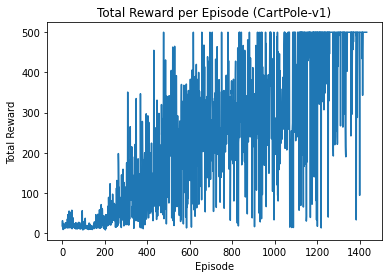

In [9]:
# Plot the total reward per episode graph
plt.plot(dqn_cartpole_reward_history)
plt.title('Total Reward per Episode (CartPole-v1)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

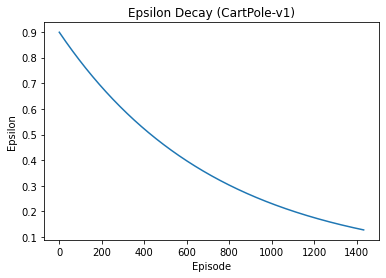

In [10]:
# Plot the epsilon decay graph
plt.plot(dqn_cartpole_epsilon_history)
plt.title('Epsilon Decay (CartPole-v1)')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

In [11]:
# evaluate the agent
eval_reward_history = agent.evaluate(num_episodes=5, render=False)

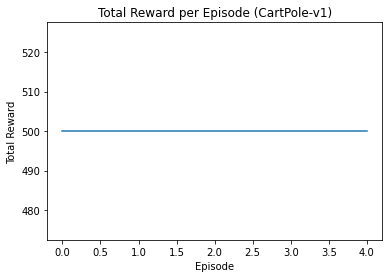

In [12]:
# Plot the total reward per episode graph
plt.plot(eval_reward_history)
plt.title('Total Reward per Episode (CartPole-v1)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

## MountainCar Environment

In [20]:
# load the MountainCar environment
env = gymnasium.make("MountainCar-v0", render_mode='rgb_array')

# init the DDQNAgent
agent = DDQNAgent(env, gamma=0.99, memory_size=80_000, batch_size=64, 
                 learning_rate=0.00001, update_target_freq=250, 
                 epsilon=0.9, epsilon_min=0.001)

In [16]:
# train the agent
dqn_mountaincar_reward_history, dqn_mountaincar_epsilon_history = agent.train(num_episodes=20_000, reward_override=True, reward_threshold=-120)

Episode: 1, Reward: -200.00, Epsilon: 0.90, XPos: -0.51, Running Mean Reward: -200.00
Episode: 2, Reward: -200.00, Epsilon: 0.90, XPos: -0.66, Running Mean Reward: -200.00
Episode: 3, Reward: -200.00, Epsilon: 0.90, XPos: -0.64, Running Mean Reward: -200.00
Episode: 4, Reward: -200.00, Epsilon: 0.90, XPos: -0.62, Running Mean Reward: -200.00
Episode: 5, Reward: -200.00, Epsilon: 0.89, XPos: -0.57, Running Mean Reward: -200.00
Episode: 6, Reward: -200.00, Epsilon: 0.89, XPos: -0.54, Running Mean Reward: -200.00
Episode: 7, Reward: -200.00, Epsilon: 0.89, XPos: -0.36, Running Mean Reward: -200.00
Episode: 8, Reward: -200.00, Epsilon: 0.89, XPos: -0.53, Running Mean Reward: -200.00
Episode: 9, Reward: -200.00, Epsilon: 0.89, XPos: -0.67, Running Mean Reward: -200.00
Episode: 10, Reward: -200.00, Epsilon: 0.89, XPos: -0.56, Running Mean Reward: -200.00
Episode: 11, Reward: -200.00, Epsilon: 0.89, XPos: -0.44, Running Mean Reward: -200.00
Episode: 12, Reward: -200.00, Epsilon: 0.89, XPos: -

Episode: 96, Reward: -200.00, Epsilon: 0.79, XPos: -0.71, Running Mean Reward: -200.00
Episode: 97, Reward: -200.00, Epsilon: 0.79, XPos: -0.46, Running Mean Reward: -200.00
Episode: 98, Reward: -200.00, Epsilon: 0.79, XPos: -0.56, Running Mean Reward: -200.00
Episode: 99, Reward: -200.00, Epsilon: 0.79, XPos: -0.58, Running Mean Reward: -200.00
Episode: 100, Reward: -200.00, Epsilon: 0.79, XPos: -0.41, Running Mean Reward: -200.00
Episode: 101, Reward: -200.00, Epsilon: 0.78, XPos: -1.06, Running Mean Reward: -200.00
Episode: 102, Reward: -200.00, Epsilon: 0.78, XPos: -0.91, Running Mean Reward: -200.00
Episode: 103, Reward: -200.00, Epsilon: 0.78, XPos: -0.31, Running Mean Reward: -200.00
Episode: 104, Reward: -200.00, Epsilon: 0.78, XPos: -0.15, Running Mean Reward: -200.00
Episode: 105, Reward: -200.00, Epsilon: 0.78, XPos: -0.41, Running Mean Reward: -200.00
Episode: 106, Reward: -200.00, Epsilon: 0.78, XPos: -0.78, Running Mean Reward: -200.00
Episode: 107, Reward: -200.00, Epsil

Episode: 190, Reward: -200.00, Epsilon: 0.69, XPos: -1.12, Running Mean Reward: -200.00
Episode: 191, Reward: -200.00, Epsilon: 0.69, XPos: -0.81, Running Mean Reward: -200.00
Episode: 192, Reward: -200.00, Epsilon: 0.69, XPos: -0.93, Running Mean Reward: -200.00
Episode: 193, Reward: -200.00, Epsilon: 0.69, XPos: -0.01, Running Mean Reward: -200.00
Episode: 194, Reward: -200.00, Epsilon: 0.69, XPos: 0.09, Running Mean Reward: -200.00
Episode: 195, Reward: -200.00, Epsilon: 0.69, XPos: -0.93, Running Mean Reward: -200.00
Episode: 196, Reward: -200.00, Epsilon: 0.69, XPos: -0.99, Running Mean Reward: -200.00
Episode: 197, Reward: -200.00, Epsilon: 0.69, XPos: -0.76, Running Mean Reward: -200.00
Episode: 198, Reward: -200.00, Epsilon: 0.69, XPos: -0.07, Running Mean Reward: -200.00
Episode: 199, Reward: -200.00, Epsilon: 0.69, XPos: -1.11, Running Mean Reward: -200.00
Episode: 200, Reward: -200.00, Epsilon: 0.69, XPos: -0.83, Running Mean Reward: -200.00
Episode: 201, Reward: -200.00, Ep

Episode: 284, Reward: -200.00, Epsilon: 0.61, XPos: 0.03, Running Mean Reward: -200.00
Episode: 285, Reward: -200.00, Epsilon: 0.61, XPos: -1.19, Running Mean Reward: -200.00
Episode: 286, Reward: -200.00, Epsilon: 0.61, XPos: -1.04, Running Mean Reward: -200.00
Episode: 287, Reward: -200.00, Epsilon: 0.61, XPos: -0.36, Running Mean Reward: -200.00
Episode: 288, Reward: -200.00, Epsilon: 0.61, XPos: -0.43, Running Mean Reward: -200.00
Episode: 289, Reward: -200.00, Epsilon: 0.61, XPos: -0.94, Running Mean Reward: -200.00
Episode: 290, Reward: -200.00, Epsilon: 0.61, XPos: -1.01, Running Mean Reward: -200.00
Episode: 291, Reward: -200.00, Epsilon: 0.61, XPos: -0.85, Running Mean Reward: -200.00
Episode: 292, Reward: -200.00, Epsilon: 0.60, XPos: -0.33, Running Mean Reward: -200.00
Episode: 293, Reward: -200.00, Epsilon: 0.60, XPos: -1.14, Running Mean Reward: -200.00
Episode: 294, Reward: -200.00, Epsilon: 0.60, XPos: -0.79, Running Mean Reward: -200.00
Episode: 295, Reward: -200.00, Ep

Episode: 378, Reward: -200.00, Epsilon: 0.54, XPos: -1.00, Running Mean Reward: -199.12
Episode: 379, Reward: -200.00, Epsilon: 0.54, XPos: -0.34, Running Mean Reward: -199.12
Episode: 380, Reward: -200.00, Epsilon: 0.54, XPos: -0.51, Running Mean Reward: -199.12
Episode: 381, Reward: -200.00, Epsilon: 0.54, XPos: -0.34, Running Mean Reward: -199.12
Episode: 382, Reward: -200.00, Epsilon: 0.54, XPos: -0.41, Running Mean Reward: -199.12
Episode: 383, Reward: -200.00, Epsilon: 0.53, XPos: 0.19, Running Mean Reward: -199.12
Episode: 384, Reward: -200.00, Epsilon: 0.53, XPos: -0.27, Running Mean Reward: -199.12
Episode: 385, Reward: -200.00, Epsilon: 0.53, XPos: -0.03, Running Mean Reward: -199.12
Episode: 386, Reward: -200.00, Epsilon: 0.53, XPos: -1.19, Running Mean Reward: -199.12
Episode: 387, Reward: -200.00, Epsilon: 0.53, XPos: -0.34, Running Mean Reward: -199.12
Episode: 388, Reward: -200.00, Epsilon: 0.53, XPos: -0.26, Running Mean Reward: -199.12
Episode: 389, Reward: -170.00, Ep

Episode: 472, Reward: -200.00, Epsilon: 0.47, XPos: 0.49, Running Mean Reward: -197.62
Episode: 473, Reward: -200.00, Epsilon: 0.47, XPos: 0.34, Running Mean Reward: -197.62
Episode: 474, Reward: -198.00, Epsilon: 0.47, XPos: 0.51, Running Mean Reward: -197.60
Episode: 475, Reward: -200.00, Epsilon: 0.47, XPos: 0.53, Running Mean Reward: -197.60
Episode: 476, Reward: -200.00, Epsilon: 0.47, XPos: 0.50, Running Mean Reward: -197.60
Episode: 477, Reward: -193.00, Epsilon: 0.47, XPos: 0.52, Running Mean Reward: -197.71
Episode: 478, Reward: -200.00, Epsilon: 0.47, XPos: 0.43, Running Mean Reward: -197.71
Episode: 479, Reward: -168.00, Epsilon: 0.47, XPos: 0.53, Running Mean Reward: -197.39
Episode: 480, Reward: -200.00, Epsilon: 0.47, XPos: 0.28, Running Mean Reward: -197.39
Episode: 481, Reward: -200.00, Epsilon: 0.47, XPos: -0.90, Running Mean Reward: -197.39
Episode: 482, Reward: -200.00, Epsilon: 0.47, XPos: 0.46, Running Mean Reward: -197.39
Episode: 483, Reward: -200.00, Epsilon: 0.

Episode: 566, Reward: -172.00, Epsilon: 0.42, XPos: 0.51, Running Mean Reward: -192.33
Episode: 567, Reward: -152.00, Epsilon: 0.42, XPos: 0.53, Running Mean Reward: -191.85
Episode: 568, Reward: -200.00, Epsilon: 0.42, XPos: -0.76, Running Mean Reward: -191.85
Episode: 569, Reward: -200.00, Epsilon: 0.42, XPos: -0.94, Running Mean Reward: -191.85
Episode: 570, Reward: -200.00, Epsilon: 0.41, XPos: -0.51, Running Mean Reward: -191.85
Episode: 571, Reward: -200.00, Epsilon: 0.41, XPos: -1.20, Running Mean Reward: -191.85
Episode: 572, Reward: -188.00, Epsilon: 0.41, XPos: 0.53, Running Mean Reward: -191.73
Episode: 573, Reward: -176.00, Epsilon: 0.41, XPos: 0.52, Running Mean Reward: -191.49
Episode: 574, Reward: -198.00, Epsilon: 0.41, XPos: 0.51, Running Mean Reward: -191.49
Episode: 575, Reward: -190.00, Epsilon: 0.41, XPos: 0.51, Running Mean Reward: -191.39
Episode: 576, Reward: -200.00, Epsilon: 0.41, XPos: -1.06, Running Mean Reward: -191.39
Episode: 577, Reward: -200.00, Epsilon

Episode: 660, Reward: -166.00, Epsilon: 0.37, XPos: 0.53, Running Mean Reward: -185.06
Episode: 661, Reward: -153.00, Epsilon: 0.37, XPos: 0.51, Running Mean Reward: -185.03
Episode: 662, Reward: -200.00, Epsilon: 0.37, XPos: -0.39, Running Mean Reward: -185.44
Episode: 663, Reward: -157.00, Epsilon: 0.37, XPos: 0.51, Running Mean Reward: -185.44
Episode: 664, Reward: -152.00, Epsilon: 0.36, XPos: 0.52, Running Mean Reward: -185.17
Episode: 665, Reward: -200.00, Epsilon: 0.36, XPos: -0.87, Running Mean Reward: -185.23
Episode: 666, Reward: -200.00, Epsilon: 0.36, XPos: -1.17, Running Mean Reward: -185.51
Episode: 667, Reward: -194.00, Epsilon: 0.36, XPos: 0.53, Running Mean Reward: -185.93
Episode: 668, Reward: -200.00, Epsilon: 0.36, XPos: -0.14, Running Mean Reward: -185.93
Episode: 669, Reward: -164.00, Epsilon: 0.36, XPos: 0.51, Running Mean Reward: -185.57
Episode: 670, Reward: -200.00, Epsilon: 0.36, XPos: 0.25, Running Mean Reward: -185.57
Episode: 671, Reward: -186.00, Epsilon:

Episode: 754, Reward: -157.00, Epsilon: 0.32, XPos: 0.53, Running Mean Reward: -174.41
Episode: 755, Reward: -119.00, Epsilon: 0.32, XPos: 0.51, Running Mean Reward: -174.08
Episode: 756, Reward: -161.00, Epsilon: 0.32, XPos: 0.50, Running Mean Reward: -173.91
Episode: 757, Reward: -159.00, Epsilon: 0.32, XPos: 0.51, Running Mean Reward: -173.83
Episode: 758, Reward: -156.00, Epsilon: 0.32, XPos: 0.50, Running Mean Reward: -173.81
Episode: 759, Reward: -153.00, Epsilon: 0.32, XPos: 0.53, Running Mean Reward: -173.71
Episode: 760, Reward: -157.00, Epsilon: 0.32, XPos: 0.53, Running Mean Reward: -173.62
Episode: 761, Reward: -187.00, Epsilon: 0.32, XPos: 0.51, Running Mean Reward: -173.96
Episode: 762, Reward: -152.00, Epsilon: 0.32, XPos: 0.51, Running Mean Reward: -173.48
Episode: 763, Reward: -196.00, Epsilon: 0.32, XPos: 0.53, Running Mean Reward: -173.87
Episode: 764, Reward: -149.00, Epsilon: 0.32, XPos: 0.52, Running Mean Reward: -173.84
Episode: 765, Reward: -152.00, Epsilon: 0.3

Episode: 849, Reward: -155.00, Epsilon: 0.28, XPos: 0.52, Running Mean Reward: -165.09
Episode: 850, Reward: -162.00, Epsilon: 0.28, XPos: 0.50, Running Mean Reward: -165.11
Episode: 851, Reward: -158.00, Epsilon: 0.28, XPos: 0.51, Running Mean Reward: -164.94
Episode: 852, Reward: -154.00, Epsilon: 0.28, XPos: 0.50, Running Mean Reward: -164.48
Episode: 853, Reward: -115.00, Epsilon: 0.28, XPos: 0.52, Running Mean Reward: -164.02
Episode: 854, Reward: -200.00, Epsilon: 0.28, XPos: -1.19, Running Mean Reward: -164.45
Episode: 855, Reward: -188.00, Epsilon: 0.28, XPos: 0.52, Running Mean Reward: -165.14
Episode: 856, Reward: -196.00, Epsilon: 0.28, XPos: 0.53, Running Mean Reward: -165.49
Episode: 857, Reward: -200.00, Epsilon: 0.28, XPos: -0.36, Running Mean Reward: -165.90
Episode: 858, Reward: -158.00, Epsilon: 0.28, XPos: 0.54, Running Mean Reward: -165.92
Episode: 859, Reward: -200.00, Epsilon: 0.28, XPos: -0.70, Running Mean Reward: -166.39
Episode: 860, Reward: -154.00, Epsilon: 

Episode: 944, Reward: -155.00, Epsilon: 0.25, XPos: 0.52, Running Mean Reward: -164.73
Episode: 945, Reward: -159.00, Epsilon: 0.25, XPos: 0.51, Running Mean Reward: -164.72
Episode: 946, Reward: -134.00, Epsilon: 0.25, XPos: 0.51, Running Mean Reward: -164.06
Episode: 947, Reward: -151.00, Epsilon: 0.25, XPos: 0.53, Running Mean Reward: -163.62
Episode: 948, Reward: -154.00, Epsilon: 0.25, XPos: 0.54, Running Mean Reward: -163.54
Episode: 949, Reward: -200.00, Epsilon: 0.25, XPos: 0.22, Running Mean Reward: -163.99
Episode: 950, Reward: -200.00, Epsilon: 0.25, XPos: -0.78, Running Mean Reward: -164.37
Episode: 951, Reward: -166.00, Epsilon: 0.25, XPos: 0.52, Running Mean Reward: -164.45
Episode: 952, Reward: -158.00, Epsilon: 0.25, XPos: 0.53, Running Mean Reward: -164.49
Episode: 953, Reward: -172.00, Epsilon: 0.25, XPos: 0.52, Running Mean Reward: -165.06
Episode: 954, Reward: -200.00, Epsilon: 0.25, XPos: 0.09, Running Mean Reward: -165.06
Episode: 955, Reward: -200.00, Epsilon: 0.

Episode: 1038, Reward: -161.00, Epsilon: 0.22, XPos: 0.52, Running Mean Reward: -165.87
Episode: 1039, Reward: -163.00, Epsilon: 0.22, XPos: 0.51, Running Mean Reward: -165.50
Episode: 1040, Reward: -200.00, Epsilon: 0.22, XPos: -0.31, Running Mean Reward: -166.28
Episode: 1041, Reward: -189.00, Epsilon: 0.22, XPos: 0.52, Running Mean Reward: -166.68
Episode: 1042, Reward: -200.00, Epsilon: 0.22, XPos: -1.09, Running Mean Reward: -167.49
Episode: 1043, Reward: -200.00, Epsilon: 0.22, XPos: -0.41, Running Mean Reward: -167.84
Episode: 1044, Reward: -154.00, Epsilon: 0.22, XPos: 0.52, Running Mean Reward: -167.83
Episode: 1045, Reward: -153.00, Epsilon: 0.22, XPos: 0.54, Running Mean Reward: -167.77
Episode: 1046, Reward: -148.00, Epsilon: 0.22, XPos: 0.52, Running Mean Reward: -167.91
Episode: 1047, Reward: -161.00, Epsilon: 0.22, XPos: 0.53, Running Mean Reward: -168.01
Episode: 1048, Reward: -156.00, Epsilon: 0.22, XPos: 0.53, Running Mean Reward: -168.03
Episode: 1049, Reward: -158.0

Episode: 1131, Reward: -200.00, Epsilon: 0.19, XPos: 0.12, Running Mean Reward: -168.40
Episode: 1132, Reward: -200.00, Epsilon: 0.19, XPos: 0.53, Running Mean Reward: -168.84
Episode: 1133, Reward: -134.00, Epsilon: 0.19, XPos: 0.51, Running Mean Reward: -168.58
Episode: 1134, Reward: -160.00, Epsilon: 0.19, XPos: 0.53, Running Mean Reward: -168.56
Episode: 1135, Reward: -128.00, Epsilon: 0.19, XPos: 0.52, Running Mean Reward: -167.84
Episode: 1136, Reward: -132.00, Epsilon: 0.19, XPos: 0.52, Running Mean Reward: -167.88
Episode: 1137, Reward: -160.00, Epsilon: 0.19, XPos: 0.54, Running Mean Reward: -167.48
Episode: 1138, Reward: -200.00, Epsilon: 0.19, XPos: 0.41, Running Mean Reward: -167.87
Episode: 1139, Reward: -127.00, Epsilon: 0.19, XPos: 0.52, Running Mean Reward: -167.51
Episode: 1140, Reward: -123.00, Epsilon: 0.19, XPos: 0.52, Running Mean Reward: -166.74
Episode: 1141, Reward: -159.00, Epsilon: 0.19, XPos: 0.55, Running Mean Reward: -166.44
Episode: 1142, Reward: -156.00, 

Episode: 1224, Reward: -123.00, Epsilon: 0.17, XPos: 0.50, Running Mean Reward: -164.11
Episode: 1225, Reward: -128.00, Epsilon: 0.17, XPos: 0.51, Running Mean Reward: -163.78
Episode: 1226, Reward: -181.00, Epsilon: 0.17, XPos: 0.50, Running Mean Reward: -163.74
Episode: 1227, Reward: -196.00, Epsilon: 0.17, XPos: 0.53, Running Mean Reward: -164.30
Episode: 1228, Reward: -160.00, Epsilon: 0.17, XPos: 0.50, Running Mean Reward: -164.46
Episode: 1229, Reward: -163.00, Epsilon: 0.17, XPos: 0.53, Running Mean Reward: -164.29
Episode: 1230, Reward: -198.00, Epsilon: 0.17, XPos: 0.54, Running Mean Reward: -165.02
Episode: 1231, Reward: -127.00, Epsilon: 0.17, XPos: 0.50, Running Mean Reward: -164.29
Episode: 1232, Reward: -196.00, Epsilon: 0.17, XPos: 0.53, Running Mean Reward: -164.25
Episode: 1233, Reward: -127.00, Epsilon: 0.17, XPos: 0.51, Running Mean Reward: -164.18
Episode: 1234, Reward: -200.00, Epsilon: 0.17, XPos: -0.43, Running Mean Reward: -164.58
Episode: 1235, Reward: -119.00,

Episode: 1317, Reward: -158.00, Epsilon: 0.15, XPos: 0.52, Running Mean Reward: -154.52
Episode: 1318, Reward: -120.00, Epsilon: 0.15, XPos: 0.50, Running Mean Reward: -154.49
Episode: 1319, Reward: -170.00, Epsilon: 0.15, XPos: 0.54, Running Mean Reward: -154.41
Episode: 1320, Reward: -116.00, Epsilon: 0.15, XPos: 0.50, Running Mean Reward: -153.57
Episode: 1321, Reward: -117.00, Epsilon: 0.15, XPos: 0.50, Running Mean Reward: -153.18
Episode: 1322, Reward: -122.00, Epsilon: 0.15, XPos: 0.51, Running Mean Reward: -152.44
Episode: 1323, Reward: -118.00, Epsilon: 0.15, XPos: 0.53, Running Mean Reward: -152.37
Episode: 1324, Reward: -114.00, Epsilon: 0.15, XPos: 0.50, Running Mean Reward: -152.28
Episode: 1325, Reward: -194.00, Epsilon: 0.15, XPos: 0.51, Running Mean Reward: -152.94
Episode: 1326, Reward: -171.00, Epsilon: 0.15, XPos: 0.51, Running Mean Reward: -152.84
Episode: 1327, Reward: -160.00, Epsilon: 0.15, XPos: 0.50, Running Mean Reward: -152.48
Episode: 1328, Reward: -152.00, 

Episode: 1411, Reward: -166.00, Epsilon: 0.13, XPos: 0.52, Running Mean Reward: -151.07
Episode: 1412, Reward: -132.00, Epsilon: 0.13, XPos: 0.51, Running Mean Reward: -151.15
Episode: 1413, Reward: -125.00, Epsilon: 0.13, XPos: 0.52, Running Mean Reward: -151.22
Episode: 1414, Reward: -130.00, Epsilon: 0.13, XPos: 0.51, Running Mean Reward: -150.95
Episode: 1415, Reward: -126.00, Epsilon: 0.13, XPos: 0.52, Running Mean Reward: -150.61
Episode: 1416, Reward: -156.00, Epsilon: 0.13, XPos: 0.54, Running Mean Reward: -150.51
Episode: 1417, Reward: -161.00, Epsilon: 0.13, XPos: 0.53, Running Mean Reward: -150.54
Episode: 1418, Reward: -163.00, Epsilon: 0.13, XPos: 0.53, Running Mean Reward: -150.97
Episode: 1419, Reward: -200.00, Epsilon: 0.13, XPos: -0.52, Running Mean Reward: -151.27
Episode: 1420, Reward: -167.00, Epsilon: 0.13, XPos: 0.54, Running Mean Reward: -151.78
Episode: 1421, Reward: -125.00, Epsilon: 0.13, XPos: 0.51, Running Mean Reward: -151.86
Episode: 1422, Reward: -162.00,

Episode: 1505, Reward: -118.00, Epsilon: 0.12, XPos: 0.54, Running Mean Reward: -154.54
Episode: 1506, Reward: -150.00, Epsilon: 0.12, XPos: 0.53, Running Mean Reward: -154.39
Episode: 1507, Reward: -155.00, Epsilon: 0.12, XPos: 0.51, Running Mean Reward: -154.24
Episode: 1508, Reward: -169.00, Epsilon: 0.12, XPos: 0.54, Running Mean Reward: -154.65
Episode: 1509, Reward: -165.00, Epsilon: 0.12, XPos: 0.54, Running Mean Reward: -155.07
Episode: 1510, Reward: -155.00, Epsilon: 0.12, XPos: 0.53, Running Mean Reward: -154.94
Episode: 1511, Reward: -160.00, Epsilon: 0.12, XPos: 0.51, Running Mean Reward: -154.88
Episode: 1512, Reward: -167.00, Epsilon: 0.12, XPos: 0.50, Running Mean Reward: -155.23
Episode: 1513, Reward: -162.00, Epsilon: 0.11, XPos: 0.53, Running Mean Reward: -155.60
Episode: 1514, Reward: -159.00, Epsilon: 0.11, XPos: 0.51, Running Mean Reward: -155.89
Episode: 1515, Reward: -160.00, Epsilon: 0.11, XPos: 0.51, Running Mean Reward: -156.23
Episode: 1516, Reward: -157.00, 

Episode: 1599, Reward: -153.00, Epsilon: 0.10, XPos: 0.54, Running Mean Reward: -157.35
Episode: 1600, Reward: -160.00, Epsilon: 0.10, XPos: 0.53, Running Mean Reward: -157.32
Episode: 1601, Reward: -152.00, Epsilon: 0.10, XPos: 0.54, Running Mean Reward: -157.33
Episode: 1602, Reward: -151.00, Epsilon: 0.10, XPos: 0.53, Running Mean Reward: -157.21
Episode: 1603, Reward: -165.00, Epsilon: 0.10, XPos: 0.51, Running Mean Reward: -157.24
Episode: 1604, Reward: -157.00, Epsilon: 0.10, XPos: 0.52, Running Mean Reward: -157.17
Episode: 1605, Reward: -143.00, Epsilon: 0.10, XPos: 0.52, Running Mean Reward: -157.42
Episode: 1606, Reward: -152.00, Epsilon: 0.10, XPos: 0.52, Running Mean Reward: -157.44
Episode: 1607, Reward: -162.00, Epsilon: 0.10, XPos: 0.54, Running Mean Reward: -157.51
Episode: 1608, Reward: -159.00, Epsilon: 0.10, XPos: 0.55, Running Mean Reward: -157.41
Episode: 1609, Reward: -157.00, Epsilon: 0.10, XPos: 0.52, Running Mean Reward: -157.33
Episode: 1610, Reward: -170.00, 

Episode: 1693, Reward: -170.00, Epsilon: 0.09, XPos: 0.52, Running Mean Reward: -156.34
Episode: 1694, Reward: -170.00, Epsilon: 0.09, XPos: 0.53, Running Mean Reward: -156.43
Episode: 1695, Reward: -168.00, Epsilon: 0.09, XPos: 0.50, Running Mean Reward: -156.50
Episode: 1696, Reward: -123.00, Epsilon: 0.09, XPos: 0.54, Running Mean Reward: -156.11
Episode: 1697, Reward: -164.00, Epsilon: 0.09, XPos: 0.51, Running Mean Reward: -156.16
Episode: 1698, Reward: -200.00, Epsilon: 0.09, XPos: 0.14, Running Mean Reward: -156.61
Episode: 1699, Reward: -159.00, Epsilon: 0.09, XPos: 0.50, Running Mean Reward: -156.67
Episode: 1700, Reward: -172.00, Epsilon: 0.09, XPos: 0.54, Running Mean Reward: -156.79
Episode: 1701, Reward: -132.00, Epsilon: 0.09, XPos: 0.53, Running Mean Reward: -156.59
Episode: 1702, Reward: -151.00, Epsilon: 0.09, XPos: 0.54, Running Mean Reward: -156.59
Episode: 1703, Reward: -168.00, Epsilon: 0.09, XPos: 0.51, Running Mean Reward: -156.62
Episode: 1704, Reward: -169.00, 

Episode: 1787, Reward: -119.00, Epsilon: 0.08, XPos: 0.52, Running Mean Reward: -158.29
Episode: 1788, Reward: -153.00, Epsilon: 0.08, XPos: 0.52, Running Mean Reward: -158.63
Episode: 1789, Reward: -124.00, Epsilon: 0.08, XPos: 0.53, Running Mean Reward: -157.89
Episode: 1790, Reward: -129.00, Epsilon: 0.08, XPos: 0.53, Running Mean Reward: -157.18
Episode: 1791, Reward: -164.00, Epsilon: 0.08, XPos: 0.51, Running Mean Reward: -157.10
Episode: 1792, Reward: -200.00, Epsilon: 0.08, XPos: -0.66, Running Mean Reward: -157.47
Episode: 1793, Reward: -161.00, Epsilon: 0.08, XPos: 0.52, Running Mean Reward: -157.38
Episode: 1794, Reward: -165.00, Epsilon: 0.08, XPos: 0.53, Running Mean Reward: -157.33
Episode: 1795, Reward: -169.00, Epsilon: 0.08, XPos: 0.51, Running Mean Reward: -157.34
Episode: 1796, Reward: -146.00, Epsilon: 0.08, XPos: 0.54, Running Mean Reward: -157.57
Episode: 1797, Reward: -168.00, Epsilon: 0.08, XPos: 0.51, Running Mean Reward: -157.61
Episode: 1798, Reward: -159.00,

Episode: 1880, Reward: -164.00, Epsilon: 0.07, XPos: 0.52, Running Mean Reward: -152.40
Episode: 1881, Reward: -169.00, Epsilon: 0.07, XPos: 0.54, Running Mean Reward: -152.85
Episode: 1882, Reward: -160.00, Epsilon: 0.07, XPos: 0.51, Running Mean Reward: -153.23
Episode: 1883, Reward: -168.00, Epsilon: 0.07, XPos: 0.54, Running Mean Reward: -153.37
Episode: 1884, Reward: -158.00, Epsilon: 0.07, XPos: 0.53, Running Mean Reward: -153.25
Episode: 1885, Reward: -158.00, Epsilon: 0.07, XPos: 0.51, Running Mean Reward: -153.17
Episode: 1886, Reward: -163.00, Epsilon: 0.07, XPos: 0.53, Running Mean Reward: -153.28
Episode: 1887, Reward: -174.00, Epsilon: 0.07, XPos: 0.52, Running Mean Reward: -153.83
Episode: 1888, Reward: -165.00, Epsilon: 0.07, XPos: 0.54, Running Mean Reward: -153.95
Episode: 1889, Reward: -159.00, Epsilon: 0.07, XPos: 0.53, Running Mean Reward: -154.30
Episode: 1890, Reward: -158.00, Epsilon: 0.07, XPos: 0.53, Running Mean Reward: -154.59
Episode: 1891, Reward: -162.00, 

Episode: 1974, Reward: -150.00, Epsilon: 0.06, XPos: 0.54, Running Mean Reward: -154.47
Episode: 1975, Reward: -169.00, Epsilon: 0.06, XPos: 0.54, Running Mean Reward: -154.64
Episode: 1976, Reward: -163.00, Epsilon: 0.06, XPos: 0.53, Running Mean Reward: -154.75
Episode: 1977, Reward: -165.00, Epsilon: 0.06, XPos: 0.54, Running Mean Reward: -154.85
Episode: 1978, Reward: -169.00, Epsilon: 0.06, XPos: 0.53, Running Mean Reward: -154.92
Episode: 1979, Reward: -147.00, Epsilon: 0.06, XPos: 0.52, Running Mean Reward: -154.78
Episode: 1980, Reward: -123.00, Epsilon: 0.06, XPos: 0.54, Running Mean Reward: -154.37
Episode: 1981, Reward: -151.00, Epsilon: 0.06, XPos: 0.52, Running Mean Reward: -154.19
Episode: 1982, Reward: -148.00, Epsilon: 0.06, XPos: 0.50, Running Mean Reward: -154.07
Episode: 1983, Reward: -171.00, Epsilon: 0.06, XPos: 0.52, Running Mean Reward: -154.10
Episode: 1984, Reward: -171.00, Epsilon: 0.06, XPos: 0.54, Running Mean Reward: -154.23
Episode: 1985, Reward: -160.00, 

Episode: 2068, Reward: -127.00, Epsilon: 0.05, XPos: 0.51, Running Mean Reward: -156.61
Episode: 2069, Reward: -173.00, Epsilon: 0.05, XPos: 0.51, Running Mean Reward: -156.67
Episode: 2070, Reward: -154.00, Epsilon: 0.05, XPos: 0.52, Running Mean Reward: -156.54
Episode: 2071, Reward: -170.00, Epsilon: 0.05, XPos: 0.50, Running Mean Reward: -156.76
Episode: 2072, Reward: -130.00, Epsilon: 0.05, XPos: 0.50, Running Mean Reward: -156.40
Episode: 2073, Reward: -170.00, Epsilon: 0.05, XPos: 0.50, Running Mean Reward: -156.54
Episode: 2074, Reward: -149.00, Epsilon: 0.05, XPos: 0.52, Running Mean Reward: -156.53
Episode: 2075, Reward: -161.00, Epsilon: 0.05, XPos: 0.53, Running Mean Reward: -156.45
Episode: 2076, Reward: -169.00, Epsilon: 0.05, XPos: 0.52, Running Mean Reward: -156.51
Episode: 2077, Reward: -154.00, Epsilon: 0.05, XPos: 0.53, Running Mean Reward: -156.40
Episode: 2078, Reward: -163.00, Epsilon: 0.05, XPos: 0.55, Running Mean Reward: -156.34
Episode: 2079, Reward: -155.00, 

Episode: 2162, Reward: -174.00, Epsilon: 0.05, XPos: 0.53, Running Mean Reward: -154.71
Episode: 2163, Reward: -165.00, Epsilon: 0.05, XPos: 0.53, Running Mean Reward: -154.68
Episode: 2164, Reward: -119.00, Epsilon: 0.05, XPos: 0.51, Running Mean Reward: -154.31
Episode: 2165, Reward: -154.00, Epsilon: 0.05, XPos: 0.53, Running Mean Reward: -154.09
Episode: 2166, Reward: -157.00, Epsilon: 0.05, XPos: 0.51, Running Mean Reward: -153.92
Episode: 2167, Reward: -118.00, Epsilon: 0.05, XPos: 0.53, Running Mean Reward: -153.43
Episode: 2168, Reward: -167.00, Epsilon: 0.05, XPos: 0.53, Running Mean Reward: -153.83
Episode: 2169, Reward: -171.00, Epsilon: 0.05, XPos: 0.51, Running Mean Reward: -153.81
Episode: 2170, Reward: -157.00, Epsilon: 0.05, XPos: 0.53, Running Mean Reward: -153.84
Episode: 2171, Reward: -170.00, Epsilon: 0.05, XPos: 0.52, Running Mean Reward: -153.84
Episode: 2172, Reward: -177.00, Epsilon: 0.05, XPos: 0.54, Running Mean Reward: -154.31
Episode: 2173, Reward: -153.00, 

Episode: 2256, Reward: -156.00, Epsilon: 0.04, XPos: 0.53, Running Mean Reward: -151.07
Episode: 2257, Reward: -155.00, Epsilon: 0.04, XPos: 0.53, Running Mean Reward: -150.94
Episode: 2258, Reward: -167.00, Epsilon: 0.04, XPos: 0.51, Running Mean Reward: -150.95
Episode: 2259, Reward: -121.00, Epsilon: 0.04, XPos: 0.52, Running Mean Reward: -150.53
Episode: 2260, Reward: -163.00, Epsilon: 0.04, XPos: 0.51, Running Mean Reward: -150.60
Episode: 2261, Reward: -110.00, Epsilon: 0.04, XPos: 0.51, Running Mean Reward: -150.02
Episode: 2262, Reward: -171.00, Epsilon: 0.04, XPos: 0.54, Running Mean Reward: -149.99
Episode: 2263, Reward: -155.00, Epsilon: 0.04, XPos: 0.53, Running Mean Reward: -149.89
Episode: 2264, Reward: -171.00, Epsilon: 0.04, XPos: 0.53, Running Mean Reward: -150.41
Episode: 2265, Reward: -174.00, Epsilon: 0.04, XPos: 0.53, Running Mean Reward: -150.61
Episode: 2266, Reward: -157.00, Epsilon: 0.04, XPos: 0.54, Running Mean Reward: -150.61
Episode: 2267, Reward: -158.00, 

Episode: 2350, Reward: -172.00, Epsilon: 0.04, XPos: 0.52, Running Mean Reward: -149.37
Episode: 2351, Reward: -192.00, Epsilon: 0.04, XPos: 0.51, Running Mean Reward: -150.15
Episode: 2352, Reward: -151.00, Epsilon: 0.04, XPos: 0.52, Running Mean Reward: -150.49
Episode: 2353, Reward: -173.00, Epsilon: 0.04, XPos: 0.54, Running Mean Reward: -150.95
Episode: 2354, Reward: -87.00, Epsilon: 0.04, XPos: 0.52, Running Mean Reward: -150.28
Episode: 2355, Reward: -165.00, Epsilon: 0.04, XPos: 0.54, Running Mean Reward: -150.39
Episode: 2356, Reward: -168.00, Epsilon: 0.04, XPos: 0.54, Running Mean Reward: -150.51
Episode: 2357, Reward: -182.00, Epsilon: 0.04, XPos: 0.50, Running Mean Reward: -150.78
Episode: 2358, Reward: -115.00, Epsilon: 0.04, XPos: 0.51, Running Mean Reward: -150.26
Episode: 2359, Reward: -160.00, Epsilon: 0.04, XPos: 0.54, Running Mean Reward: -150.65
Episode: 2360, Reward: -152.00, Epsilon: 0.04, XPos: 0.55, Running Mean Reward: -150.54
Episode: 2361, Reward: -168.00, E

Episode: 2444, Reward: -170.00, Epsilon: 0.03, XPos: 0.51, Running Mean Reward: -144.88
Episode: 2445, Reward: -173.00, Epsilon: 0.03, XPos: 0.54, Running Mean Reward: -144.91
Episode: 2446, Reward: -151.00, Epsilon: 0.03, XPos: 0.54, Running Mean Reward: -144.81
Episode: 2447, Reward: -168.00, Epsilon: 0.03, XPos: 0.54, Running Mean Reward: -144.90
Episode: 2448, Reward: -155.00, Epsilon: 0.03, XPos: 0.54, Running Mean Reward: -144.79
Episode: 2449, Reward: -87.00, Epsilon: 0.03, XPos: 0.52, Running Mean Reward: -143.72
Episode: 2450, Reward: -167.00, Epsilon: 0.03, XPos: 0.50, Running Mean Reward: -143.67
Episode: 2451, Reward: -175.00, Epsilon: 0.03, XPos: 0.52, Running Mean Reward: -143.50
Episode: 2452, Reward: -147.00, Epsilon: 0.03, XPos: 0.51, Running Mean Reward: -143.46
Episode: 2453, Reward: -170.00, Epsilon: 0.03, XPos: 0.50, Running Mean Reward: -143.43
Episode: 2454, Reward: -89.00, Epsilon: 0.03, XPos: 0.51, Running Mean Reward: -143.45
Episode: 2455, Reward: -159.00, Ep

Episode: 2538, Reward: -90.00, Epsilon: 0.03, XPos: 0.51, Running Mean Reward: -152.56
Episode: 2539, Reward: -160.00, Epsilon: 0.03, XPos: 0.52, Running Mean Reward: -152.60
Episode: 2540, Reward: -147.00, Epsilon: 0.03, XPos: 0.53, Running Mean Reward: -152.54
Episode: 2541, Reward: -200.00, Epsilon: 0.03, XPos: -0.98, Running Mean Reward: -152.81
Episode: 2542, Reward: -172.00, Epsilon: 0.03, XPos: 0.52, Running Mean Reward: -152.79
Episode: 2543, Reward: -86.00, Epsilon: 0.03, XPos: 0.51, Running Mean Reward: -152.10
Episode: 2544, Reward: -158.00, Epsilon: 0.03, XPos: 0.51, Running Mean Reward: -151.98
Episode: 2545, Reward: -85.00, Epsilon: 0.03, XPos: 0.50, Running Mean Reward: -151.10
Episode: 2546, Reward: -164.00, Epsilon: 0.03, XPos: 0.52, Running Mean Reward: -151.23
Episode: 2547, Reward: -144.00, Epsilon: 0.03, XPos: 0.53, Running Mean Reward: -150.99
Episode: 2548, Reward: -154.00, Epsilon: 0.03, XPos: 0.52, Running Mean Reward: -150.98
Episode: 2549, Reward: -142.00, Ep

Episode: 2632, Reward: -86.00, Epsilon: 0.03, XPos: 0.50, Running Mean Reward: -144.01
Episode: 2633, Reward: -87.00, Epsilon: 0.03, XPos: 0.50, Running Mean Reward: -143.44
Episode: 2634, Reward: -179.00, Epsilon: 0.03, XPos: 0.53, Running Mean Reward: -144.36
Episode: 2635, Reward: -87.00, Epsilon: 0.02, XPos: 0.52, Running Mean Reward: -143.77
Episode: 2636, Reward: -168.00, Epsilon: 0.02, XPos: 0.54, Running Mean Reward: -144.00
Episode: 2637, Reward: -169.00, Epsilon: 0.02, XPos: 0.52, Running Mean Reward: -144.30
Episode: 2638, Reward: -142.00, Epsilon: 0.02, XPos: 0.54, Running Mean Reward: -144.82
Episode: 2639, Reward: -148.00, Epsilon: 0.02, XPos: 0.54, Running Mean Reward: -144.70
Episode: 2640, Reward: -142.00, Epsilon: 0.02, XPos: 0.54, Running Mean Reward: -144.65
Episode: 2641, Reward: -159.00, Epsilon: 0.02, XPos: 0.52, Running Mean Reward: -144.24
Episode: 2642, Reward: -147.00, Epsilon: 0.02, XPos: 0.51, Running Mean Reward: -143.99
Episode: 2643, Reward: -122.00, Eps

Episode: 2726, Reward: -144.00, Epsilon: 0.02, XPos: 0.53, Running Mean Reward: -146.92
Episode: 2727, Reward: -167.00, Epsilon: 0.02, XPos: 0.51, Running Mean Reward: -146.94
Episode: 2728, Reward: -188.00, Epsilon: 0.02, XPos: 0.50, Running Mean Reward: -147.38
Episode: 2729, Reward: -86.00, Epsilon: 0.02, XPos: 0.51, Running Mean Reward: -146.65
Episode: 2730, Reward: -161.00, Epsilon: 0.02, XPos: 0.54, Running Mean Reward: -146.74
Episode: 2731, Reward: -115.00, Epsilon: 0.02, XPos: 0.52, Running Mean Reward: -146.73
Episode: 2732, Reward: -168.00, Epsilon: 0.02, XPos: 0.52, Running Mean Reward: -147.55
Episode: 2733, Reward: -113.00, Epsilon: 0.02, XPos: 0.54, Running Mean Reward: -147.81
Episode: 2734, Reward: -169.00, Epsilon: 0.02, XPos: 0.51, Running Mean Reward: -147.71
Episode: 2735, Reward: -115.00, Epsilon: 0.02, XPos: 0.53, Running Mean Reward: -147.99
Episode: 2736, Reward: -87.00, Epsilon: 0.02, XPos: 0.50, Running Mean Reward: -147.18
Episode: 2737, Reward: -151.00, Ep

Episode: 2820, Reward: -142.00, Epsilon: 0.02, XPos: 0.51, Running Mean Reward: -138.48
Episode: 2821, Reward: -117.00, Epsilon: 0.02, XPos: 0.52, Running Mean Reward: -138.38
Episode: 2822, Reward: -173.00, Epsilon: 0.02, XPos: 0.52, Running Mean Reward: -139.24
Episode: 2823, Reward: -118.00, Epsilon: 0.02, XPos: 0.54, Running Mean Reward: -138.96
Episode: 2824, Reward: -94.00, Epsilon: 0.02, XPos: 0.51, Running Mean Reward: -138.26
Episode: 2825, Reward: -88.00, Epsilon: 0.02, XPos: 0.52, Running Mean Reward: -137.52
Episode: 2826, Reward: -92.00, Epsilon: 0.02, XPos: 0.50, Running Mean Reward: -137.00
Episode: 2827, Reward: -149.00, Epsilon: 0.02, XPos: 0.54, Running Mean Reward: -136.82
Episode: 2828, Reward: -149.00, Epsilon: 0.02, XPos: 0.52, Running Mean Reward: -136.43
Episode: 2829, Reward: -174.00, Epsilon: 0.02, XPos: 0.52, Running Mean Reward: -137.31
Episode: 2830, Reward: -151.00, Epsilon: 0.02, XPos: 0.52, Running Mean Reward: -137.21
Episode: 2831, Reward: -84.00, Epsi

Episode: 2914, Reward: -112.00, Epsilon: 0.02, XPos: 0.54, Running Mean Reward: -136.36
Episode: 2915, Reward: -85.00, Epsilon: 0.02, XPos: 0.51, Running Mean Reward: -135.45
Episode: 2916, Reward: -85.00, Epsilon: 0.02, XPos: 0.50, Running Mean Reward: -134.57
Episode: 2917, Reward: -173.00, Epsilon: 0.02, XPos: 0.51, Running Mean Reward: -134.75
Episode: 2918, Reward: -154.00, Epsilon: 0.02, XPos: 0.54, Running Mean Reward: -134.69
Episode: 2919, Reward: -154.00, Epsilon: 0.02, XPos: 0.54, Running Mean Reward: -134.83
Episode: 2920, Reward: -110.00, Epsilon: 0.02, XPos: 0.52, Running Mean Reward: -134.51
Episode: 2921, Reward: -113.00, Epsilon: 0.02, XPos: 0.54, Running Mean Reward: -134.47
Episode: 2922, Reward: -113.00, Epsilon: 0.02, XPos: 0.52, Running Mean Reward: -133.87
Episode: 2923, Reward: -174.00, Epsilon: 0.02, XPos: 0.53, Running Mean Reward: -134.43
Episode: 2924, Reward: -200.00, Epsilon: 0.02, XPos: 0.34, Running Mean Reward: -135.49
Episode: 2925, Reward: -109.00, Ep

In [17]:
# save the weights of the model
os.makedirs("./weights", exist_ok=True)
agent.save_weights("./weights/ddqn_mountaincar.weights.h5")

In [23]:
# load the weights of the model
agent.load_weights("./weights/dqn_mountaincar.weights_new.h5")

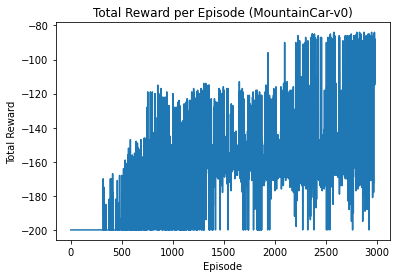

In [19]:
# plot the total reward per episode graph
plt.plot(dqn_mountaincar_reward_history)
plt.title('Total Reward per Episode (MountainCar-v0)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

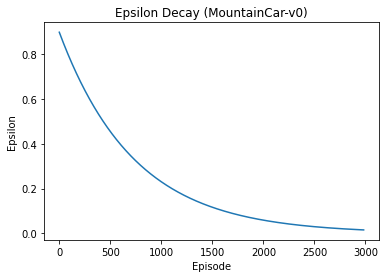

In [20]:
# plot the epsilon decay graph
plt.plot(dqn_mountaincar_epsilon_history)
plt.title('Epsilon Decay (MountainCar-v0)')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

In [24]:
# evaluate the agent
eval_reward_history = agent.evaluate(num_episodes=5, render=False)

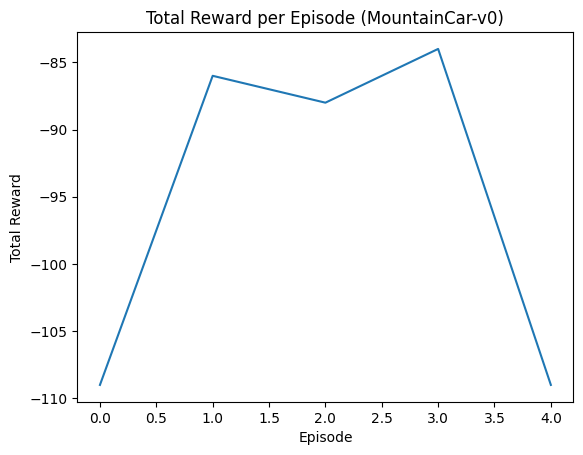

In [25]:
# plot the total reward per episode graph
plt.plot(eval_reward_history)
plt.title('Total Reward per Episode (MountainCar-v0)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

## GridWorld Environment

### Assignment1 Code for GridWorld

> Minor changes were made to the code to make it compatible with the DQN algorithm.

In [25]:
# Action ENUM
class Action(Enum):
    DOWN = 0
    UP = 1
    RIGHT = 2
    LEFT = 3

In [26]:
class Assets:
    tom = './gridworld/tom.png'
    jerry = './gridworld/jerry.png'
    cheese = './gridworld/cheese.png'
    mousetrap = './gridworld/mousetrap.png'
    popcorn = './gridworld/popcorn.png'
    jerry_cheese = './gridworld/jerry_cheese.png'
    jerry_mousetrap = './gridworld/jerry_mousetrap.png'
    jerry_popcorn = './gridworld/jerry_popcorn.png'
    jerry_tom = './gridworld/jerry_tom.png'
    background = './gridworld/background.png'

In [27]:
"""
Definition of the Grid Env class.

Referaences: RL Env Creation and Random Agent Demo
"""
class DeterministicGridEnv(gymnasium.Env):
    # Attribute of a Gym class that provides info about the render modes
    metadata = {"render.modes": []}

    # Initialization function
    def __init__(self, rows, cols, max_timesteps, start_pos, goal_pos, rewards_map):

        self.observation_space = spaces.Box(low=0, high=1, shape=(rows * cols,), dtype=np.int32)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = max_timesteps
        self.rows = rows
        self.cols = cols
        self.start_pos = start_pos
        self.goal_pos = goal_pos
        self.init_rewards_map = rewards_map
        self.rewards_map = rewards_map.copy()

        self.timestep = 0
        self.reset()

    # Reset function
    def reset(self):
        self.state = np.zeros((self.rows, self.cols))
        self.rewards_map = self.init_rewards_map.copy()
        self.agent_pos = self.start_pos.copy()
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        observation = self.state.flatten()
        self.timestep = 0

        info = {}

        return observation, info

    # Step function: Contains the implementation for what happens when an
    # agent takes a step in the environment.
    def step(self, action):
        # check if the agent is on a reward cell
        if tuple(self.agent_pos) in self.rewards_map:
            # remove the reward from the map
            self.rewards_map.pop(tuple(self.agent_pos))
        
        next_pos = self.agent_pos.copy()

        if action == Action.DOWN.value:
            next_pos[0] += 1
        elif action == Action.UP.value:
            next_pos[0] -= 1
        elif action == Action.RIGHT.value:
            next_pos[1] += 1
        elif action == Action.LEFT.value:
            next_pos[1] -= 1

        if 0 <= next_pos[0] < self.rows and 0 <= next_pos[1] < self.cols:
            self.agent_pos = next_pos

        self.state = np.zeros((self.rows, self.cols))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        observation = self.state.flatten()
        info = {}

        # check rewards map for reward
        reward = -1
        if tuple(self.agent_pos) in self.rewards_map:
            reward = self.rewards_map[tuple(self.agent_pos)]

        self.timestep += 1

        # Condition to check for termination (episode is over)
        terminated = (
            True
            if (
                (self.timestep >= self.max_timesteps)
                or np.array_equal(self.agent_pos, self.goal_pos)
            )
            else False
        )

        # Condition to check if agent is traversing to a cell beyond the permitted cells
        # This helps the agent to learn how to behave in a safe and predictable manner
        truncated = (
            False
            if (
                0 <= self.agent_pos[0] < self.rows
                and 0 <= self.agent_pos[1] < self.cols
            )
            else True
        )

        return observation, reward, terminated, truncated, info

    # Render function: Visualizes the environment
    def render(self, mode="human"):
        fig, ax = plt.subplots()
        ax.set_xlim(0, self.cols)
        ax.set_ylim(0, self.rows)
        ax.set_xticks(range(self.cols + 1))
        ax.set_yticks(range(self.rows + 1))
        ax.grid(which="both", color='gray', linewidth=2)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.invert_yaxis()
        
        # Load and display the background image for the entire grid
        background_img = mpimg.imread(Assets.background)
        ax.imshow(background_img, extent=[0, self.cols, 0, self.rows], aspect='auto', origin='lower')

        # Loop through all cells in the grid and place images
        for r in range(self.rows):
            for c in range(self.cols):
                img = None
                
                # Determine the correct image based on the agent's position and the rewards_map
                if (r, c) == tuple(self.agent_pos):
                    if (r, c) in self.rewards_map:
                        reward = self.rewards_map[(r, c)]
                        if reward == 2:  # Popcorn
                            img = mpimg.imread(Assets.jerry_popcorn)
                        elif reward == -5:  # Tom
                            img = mpimg.imread(Assets.jerry_tom)
                        elif reward == -2:  # Mousetrap
                            img = mpimg.imread(Assets.jerry_mousetrap)
                        elif reward == 10:  # Cheese
                            img = mpimg.imread(Assets.jerry_cheese)
                        else:
                            img = mpimg.imread(
                                Assets.jerry
                            )  # Default to just Jerry if no special case
                    else:
                        img = mpimg.imread(Assets.jerry)  # Default to Jerry

                # For non-agent cells, check if they contain other items
                elif (r, c) in self.rewards_map:
                    reward = self.rewards_map[(r, c)]
                    if reward == 2:  # Popcorn
                        img = mpimg.imread(Assets.popcorn)
                    elif reward == -5:  # Tom
                        img = mpimg.imread(Assets.tom)
                    elif reward == -2:  # Mousetrap
                        img = mpimg.imread(Assets.mousetrap)
                    elif reward == 10:  # Cheese
                        img = mpimg.imread(Assets.cheese)
                        
                if img is not None:
                    ax.imshow(img, extent=[c, c + 1, r, r + 1], origin="lower")

        plt.show()


In [28]:
# Define 4 rewards for the agent to collect
rewards_map = {
    (0, 1): 2,
    (2, 1): -5,
    (1, 3): -2,
    (2, 3): 10
}

# Initialize the environment
d_env = DeterministicGridEnv(3, 4, 10, [0, 0], [2, 3], rewards_map)
d_env.unwrapped.spec = gymnasium.envs.registration.EnvSpec("DeterministicGridEnv-v0")

In [29]:
# initialize the agent
agent = DDQNAgent(d_env, update_target_freq=100)

In [30]:
# train the agent
dqn_gridworld_reward_history, dqn_gridworld_epsilon_history = agent.train(num_episodes=10_000, reward_threshold=8.5)

Episode: 1, Reward: -10.00, Epsilon: 1.00, Steps: 10, Running Mean Reward: -10.00
Episode: 2, Reward: -14.00, Epsilon: 1.00, Steps: 20, Running Mean Reward: -12.00
Episode: 3, Reward: -10.00, Epsilon: 0.99, Steps: 30, Running Mean Reward: -11.33
Episode: 4, Reward: -10.00, Epsilon: 0.99, Steps: 40, Running Mean Reward: -11.00
Episode: 5, Reward: -14.00, Epsilon: 0.99, Steps: 50, Running Mean Reward: -11.60
Episode: 6, Reward: -10.00, Epsilon: 0.99, Steps: 60, Running Mean Reward: -11.33
Episode: 7, Reward: 2.00, Epsilon: 0.99, Steps: 68, Running Mean Reward: -9.43
Episode: 8, Reward: -11.00, Epsilon: 0.99, Steps: 78, Running Mean Reward: -9.62
Episode: 9, Reward: -10.00, Epsilon: 0.98, Steps: 88, Running Mean Reward: -9.67
Episode: 10, Reward: -7.00, Epsilon: 0.98, Steps: 98, Running Mean Reward: -9.40
Episode: 11, Reward: -11.00, Epsilon: 0.98, Steps: 108, Running Mean Reward: -9.55
Episode: 12, Reward: -7.00, Epsilon: 0.98, Steps: 118, Running Mean Reward: -9.33
Episode: 13, Reward: 

Episode: 105, Reward: -11.00, Epsilon: 0.82, Steps: 1033, Running Mean Reward: -8.46
Episode: 106, Reward: -7.00, Epsilon: 0.82, Steps: 1043, Running Mean Reward: -8.43
Episode: 107, Reward: 7.00, Epsilon: 0.82, Steps: 1049, Running Mean Reward: -8.38
Episode: 108, Reward: -7.00, Epsilon: 0.82, Steps: 1059, Running Mean Reward: -8.34
Episode: 109, Reward: -11.00, Epsilon: 0.82, Steps: 1069, Running Mean Reward: -8.35
Episode: 110, Reward: -7.00, Epsilon: 0.82, Steps: 1079, Running Mean Reward: -8.35
Episode: 111, Reward: -11.00, Epsilon: 0.82, Steps: 1089, Running Mean Reward: -8.35
Episode: 112, Reward: -12.00, Epsilon: 0.81, Steps: 1099, Running Mean Reward: -8.40
Episode: 113, Reward: 0.00, Epsilon: 0.81, Steps: 1106, Running Mean Reward: -8.28
Episode: 114, Reward: -10.00, Epsilon: 0.81, Steps: 1116, Running Mean Reward: -8.27
Episode: 115, Reward: -11.00, Epsilon: 0.81, Steps: 1126, Running Mean Reward: -8.28
Episode: 116, Reward: -7.00, Epsilon: 0.81, Steps: 1136, Running Mean Re

Episode: 213, Reward: -11.00, Epsilon: 0.68, Steps: 2024, Running Mean Reward: -3.88
Episode: 214, Reward: 7.00, Epsilon: 0.67, Steps: 2030, Running Mean Reward: -3.71
Episode: 215, Reward: -7.00, Epsilon: 0.67, Steps: 2040, Running Mean Reward: -3.67
Episode: 216, Reward: 4.00, Epsilon: 0.67, Steps: 2049, Running Mean Reward: -3.56
Episode: 217, Reward: -8.00, Epsilon: 0.67, Steps: 2059, Running Mean Reward: -3.56
Episode: 218, Reward: -8.00, Epsilon: 0.67, Steps: 2069, Running Mean Reward: -3.57
Episode: 219, Reward: -7.00, Epsilon: 0.67, Steps: 2079, Running Mean Reward: -3.56
Episode: 220, Reward: 6.00, Epsilon: 0.67, Steps: 2086, Running Mean Reward: -3.43
Episode: 221, Reward: 6.00, Epsilon: 0.67, Steps: 2091, Running Mean Reward: -3.30
Episode: 222, Reward: -7.00, Epsilon: 0.66, Steps: 2101, Running Mean Reward: -3.30
Episode: 223, Reward: 6.00, Epsilon: 0.66, Steps: 2108, Running Mean Reward: -3.17
Episode: 224, Reward: -11.00, Epsilon: 0.66, Steps: 2118, Running Mean Reward: -

Episode: 320, Reward: -11.00, Epsilon: 0.55, Steps: 2970, Running Mean Reward: -1.76
Episode: 321, Reward: 3.00, Epsilon: 0.55, Steps: 2980, Running Mean Reward: -1.79
Episode: 322, Reward: 5.00, Epsilon: 0.55, Steps: 2988, Running Mean Reward: -1.67
Episode: 323, Reward: 4.00, Epsilon: 0.55, Steps: 2995, Running Mean Reward: -1.69
Episode: 324, Reward: -8.00, Epsilon: 0.55, Steps: 3005, Running Mean Reward: -1.66
Episode: 325, Reward: -8.00, Epsilon: 0.55, Steps: 3015, Running Mean Reward: -1.67
Episode: 326, Reward: 6.00, Epsilon: 0.55, Steps: 3022, Running Mean Reward: -1.50
Episode: 327, Reward: 5.00, Epsilon: 0.55, Steps: 3027, Running Mean Reward: -1.38
Episode: 328, Reward: 5.00, Epsilon: 0.55, Steps: 3035, Running Mean Reward: -1.26
Episode: 329, Reward: -7.00, Epsilon: 0.55, Steps: 3045, Running Mean Reward: -1.26
Episode: 330, Reward: 4.00, Epsilon: 0.54, Steps: 3054, Running Mean Reward: -1.14
Episode: 331, Reward: -8.00, Epsilon: 0.54, Steps: 3064, Running Mean Reward: -1.1

Episode: 426, Reward: -11.00, Epsilon: 0.46, Steps: 3795, Running Mean Reward: 1.36
Episode: 427, Reward: 8.00, Epsilon: 0.46, Steps: 3800, Running Mean Reward: 1.39
Episode: 428, Reward: 3.00, Epsilon: 0.45, Steps: 3807, Running Mean Reward: 1.37
Episode: 429, Reward: 8.00, Epsilon: 0.45, Steps: 3813, Running Mean Reward: 1.52
Episode: 430, Reward: 4.00, Epsilon: 0.45, Steps: 3823, Running Mean Reward: 1.52
Episode: 431, Reward: -14.00, Epsilon: 0.45, Steps: 3833, Running Mean Reward: 1.46
Episode: 432, Reward: 0.00, Epsilon: 0.45, Steps: 3843, Running Mean Reward: 1.39
Episode: 433, Reward: -7.00, Epsilon: 0.45, Steps: 3853, Running Mean Reward: 1.24
Episode: 434, Reward: 8.00, Epsilon: 0.45, Steps: 3858, Running Mean Reward: 1.26
Episode: 435, Reward: -7.00, Epsilon: 0.45, Steps: 3868, Running Mean Reward: 1.27
Episode: 436, Reward: -8.00, Epsilon: 0.45, Steps: 3878, Running Mean Reward: 1.31
Episode: 437, Reward: 8.00, Epsilon: 0.45, Steps: 3883, Running Mean Reward: 1.46
Episode: 

Episode: 531, Reward: 3.00, Epsilon: 0.38, Steps: 4576, Running Mean Reward: 2.41
Episode: 532, Reward: -7.00, Epsilon: 0.38, Steps: 4586, Running Mean Reward: 2.34
Episode: 533, Reward: -7.00, Epsilon: 0.37, Steps: 4596, Running Mean Reward: 2.34
Episode: 534, Reward: -7.00, Epsilon: 0.37, Steps: 4606, Running Mean Reward: 2.19
Episode: 535, Reward: 9.00, Epsilon: 0.37, Steps: 4611, Running Mean Reward: 2.35
Episode: 536, Reward: -7.00, Epsilon: 0.37, Steps: 4621, Running Mean Reward: 2.36
Episode: 537, Reward: 9.00, Epsilon: 0.37, Steps: 4626, Running Mean Reward: 2.37
Episode: 538, Reward: -7.00, Epsilon: 0.37, Steps: 4636, Running Mean Reward: 2.22
Episode: 539, Reward: -7.00, Epsilon: 0.37, Steps: 4646, Running Mean Reward: 2.12
Episode: 540, Reward: 4.00, Epsilon: 0.37, Steps: 4656, Running Mean Reward: 2.23
Episode: 541, Reward: -7.00, Epsilon: 0.37, Steps: 4666, Running Mean Reward: 2.13
Episode: 542, Reward: 9.00, Epsilon: 0.37, Steps: 4671, Running Mean Reward: 2.29
Episode: 

Episode: 638, Reward: 5.00, Epsilon: 0.31, Steps: 5424, Running Mean Reward: 1.65
Episode: 639, Reward: 9.00, Epsilon: 0.31, Steps: 5429, Running Mean Reward: 1.81
Episode: 640, Reward: -7.00, Epsilon: 0.31, Steps: 5439, Running Mean Reward: 1.70
Episode: 641, Reward: 5.00, Epsilon: 0.31, Steps: 5448, Running Mean Reward: 1.82
Episode: 642, Reward: 6.00, Epsilon: 0.31, Steps: 5455, Running Mean Reward: 1.79
Episode: 643, Reward: 7.00, Epsilon: 0.31, Steps: 5461, Running Mean Reward: 1.81
Episode: 644, Reward: 7.00, Epsilon: 0.31, Steps: 5468, Running Mean Reward: 1.96
Episode: 645, Reward: 5.00, Epsilon: 0.30, Steps: 5476, Running Mean Reward: 2.12
Episode: 646, Reward: 8.00, Epsilon: 0.30, Steps: 5481, Running Mean Reward: 2.15
Episode: 647, Reward: 0.00, Epsilon: 0.30, Steps: 5488, Running Mean Reward: 2.12
Episode: 648, Reward: 4.00, Epsilon: 0.30, Steps: 5497, Running Mean Reward: 2.11
Episode: 649, Reward: 3.00, Epsilon: 0.30, Steps: 5507, Running Mean Reward: 2.21
Episode: 650, R

Episode: 741, Reward: 2.00, Epsilon: 0.26, Steps: 6157, Running Mean Reward: 3.82
Episode: 742, Reward: 9.00, Epsilon: 0.25, Steps: 6162, Running Mean Reward: 3.85
Episode: 743, Reward: 3.00, Epsilon: 0.25, Steps: 6169, Running Mean Reward: 3.81
Episode: 744, Reward: 7.00, Epsilon: 0.25, Steps: 6176, Running Mean Reward: 3.81
Episode: 745, Reward: 6.00, Epsilon: 0.25, Steps: 6181, Running Mean Reward: 3.82
Episode: 746, Reward: 4.00, Epsilon: 0.25, Steps: 6187, Running Mean Reward: 3.78
Episode: 747, Reward: 7.00, Epsilon: 0.25, Steps: 6194, Running Mean Reward: 3.85
Episode: 748, Reward: 7.00, Epsilon: 0.25, Steps: 6201, Running Mean Reward: 3.88
Episode: 749, Reward: -8.00, Epsilon: 0.25, Steps: 6211, Running Mean Reward: 3.77
Episode: 750, Reward: -7.00, Epsilon: 0.25, Steps: 6221, Running Mean Reward: 3.68
Episode: 751, Reward: 5.00, Epsilon: 0.25, Steps: 6230, Running Mean Reward: 3.65
Episode: 752, Reward: 9.00, Epsilon: 0.25, Steps: 6235, Running Mean Reward: 3.67
Episode: 753, 

Episode: 843, Reward: 6.00, Epsilon: 0.21, Steps: 6880, Running Mean Reward: 3.93
Episode: 844, Reward: 8.00, Epsilon: 0.21, Steps: 6885, Running Mean Reward: 3.94
Episode: 845, Reward: 6.00, Epsilon: 0.21, Steps: 6892, Running Mean Reward: 3.94
Episode: 846, Reward: 8.00, Epsilon: 0.21, Steps: 6897, Running Mean Reward: 3.98
Episode: 847, Reward: 7.00, Epsilon: 0.21, Steps: 6903, Running Mean Reward: 3.98
Episode: 848, Reward: 8.00, Epsilon: 0.21, Steps: 6908, Running Mean Reward: 3.99
Episode: 849, Reward: 6.00, Epsilon: 0.21, Steps: 6913, Running Mean Reward: 4.13
Episode: 850, Reward: 7.00, Epsilon: 0.21, Steps: 6919, Running Mean Reward: 4.27
Episode: 851, Reward: -8.00, Epsilon: 0.21, Steps: 6929, Running Mean Reward: 4.14
Episode: 852, Reward: 6.00, Epsilon: 0.21, Steps: 6937, Running Mean Reward: 4.11
Episode: 853, Reward: 6.00, Epsilon: 0.21, Steps: 6944, Running Mean Reward: 4.08
Episode: 854, Reward: 7.00, Epsilon: 0.21, Steps: 6951, Running Mean Reward: 4.10
Episode: 855, R

Episode: 946, Reward: 9.00, Epsilon: 0.18, Steps: 7496, Running Mean Reward: 7.20
Episode: 947, Reward: 8.00, Epsilon: 0.17, Steps: 7502, Running Mean Reward: 7.21
Episode: 948, Reward: 2.00, Epsilon: 0.17, Steps: 7511, Running Mean Reward: 7.15
Episode: 949, Reward: 7.00, Epsilon: 0.17, Steps: 7518, Running Mean Reward: 7.16
Episode: 950, Reward: 9.00, Epsilon: 0.17, Steps: 7523, Running Mean Reward: 7.18
Episode: 951, Reward: 9.00, Epsilon: 0.17, Steps: 7528, Running Mean Reward: 7.35
Episode: 952, Reward: 9.00, Epsilon: 0.17, Steps: 7533, Running Mean Reward: 7.38
Episode: 953, Reward: 6.00, Epsilon: 0.17, Steps: 7541, Running Mean Reward: 7.38
Episode: 954, Reward: 7.00, Epsilon: 0.17, Steps: 7547, Running Mean Reward: 7.38
Episode: 955, Reward: 8.00, Epsilon: 0.17, Steps: 7553, Running Mean Reward: 7.38
Episode: 956, Reward: 6.00, Epsilon: 0.17, Steps: 7558, Running Mean Reward: 7.37
Episode: 957, Reward: 9.00, Epsilon: 0.17, Steps: 7563, Running Mean Reward: 7.39
Episode: 958, Re

Episode: 1054, Reward: 8.00, Epsilon: 0.14, Steps: 8113, Running Mean Reward: 7.88
Episode: 1055, Reward: 9.00, Epsilon: 0.14, Steps: 8118, Running Mean Reward: 7.89
Episode: 1056, Reward: 9.00, Epsilon: 0.14, Steps: 8123, Running Mean Reward: 7.92
Episode: 1057, Reward: 7.00, Epsilon: 0.14, Steps: 8130, Running Mean Reward: 7.90
Episode: 1058, Reward: 2.00, Epsilon: 0.14, Steps: 8139, Running Mean Reward: 7.86
Episode: 1059, Reward: 9.00, Epsilon: 0.14, Steps: 8144, Running Mean Reward: 7.87
Episode: 1060, Reward: 9.00, Epsilon: 0.14, Steps: 8149, Running Mean Reward: 7.87
Episode: 1061, Reward: 9.00, Epsilon: 0.14, Steps: 8154, Running Mean Reward: 7.89
Episode: 1062, Reward: 9.00, Epsilon: 0.14, Steps: 8159, Running Mean Reward: 7.89
Episode: 1063, Reward: 9.00, Epsilon: 0.14, Steps: 8164, Running Mean Reward: 7.93
Episode: 1064, Reward: 7.00, Epsilon: 0.14, Steps: 8171, Running Mean Reward: 7.92
Episode: 1065, Reward: 8.00, Epsilon: 0.14, Steps: 8177, Running Mean Reward: 7.91
Epis

Episode: 1163, Reward: 6.00, Epsilon: 0.12, Steps: 8737, Running Mean Reward: 7.60
Episode: 1164, Reward: 8.00, Epsilon: 0.12, Steps: 8742, Running Mean Reward: 7.61
Episode: 1165, Reward: 8.00, Epsilon: 0.12, Steps: 8747, Running Mean Reward: 7.61
Episode: 1166, Reward: 8.00, Epsilon: 0.12, Steps: 8752, Running Mean Reward: 7.66
Episode: 1167, Reward: 8.00, Epsilon: 0.12, Steps: 8757, Running Mean Reward: 7.67
Episode: 1168, Reward: 7.00, Epsilon: 0.12, Steps: 8763, Running Mean Reward: 7.66
Episode: 1169, Reward: 9.00, Epsilon: 0.12, Steps: 8768, Running Mean Reward: 7.68
Episode: 1170, Reward: 6.00, Epsilon: 0.12, Steps: 8773, Running Mean Reward: 7.65
Episode: 1171, Reward: 8.00, Epsilon: 0.12, Steps: 8778, Running Mean Reward: 7.67
Episode: 1172, Reward: 7.00, Epsilon: 0.12, Steps: 8784, Running Mean Reward: 7.67
Episode: 1173, Reward: 8.00, Epsilon: 0.12, Steps: 8789, Running Mean Reward: 7.66
Episode: 1174, Reward: 8.00, Epsilon: 0.12, Steps: 8794, Running Mean Reward: 7.74
Epis

Episode: 1271, Reward: 9.00, Epsilon: 0.10, Steps: 9345, Running Mean Reward: 7.85
Episode: 1272, Reward: 9.00, Epsilon: 0.10, Steps: 9350, Running Mean Reward: 7.87
Episode: 1273, Reward: 9.00, Epsilon: 0.10, Steps: 9355, Running Mean Reward: 7.88
Episode: 1274, Reward: 9.00, Epsilon: 0.10, Steps: 9360, Running Mean Reward: 7.89
Episode: 1275, Reward: 8.00, Epsilon: 0.10, Steps: 9366, Running Mean Reward: 7.89
Episode: 1276, Reward: 9.00, Epsilon: 0.10, Steps: 9371, Running Mean Reward: 7.90
Episode: 1277, Reward: 9.00, Epsilon: 0.10, Steps: 9376, Running Mean Reward: 7.93
Episode: 1278, Reward: 9.00, Epsilon: 0.09, Steps: 9381, Running Mean Reward: 7.93
Episode: 1279, Reward: 8.00, Epsilon: 0.09, Steps: 9387, Running Mean Reward: 7.92
Episode: 1280, Reward: 9.00, Epsilon: 0.09, Steps: 9392, Running Mean Reward: 7.92
Episode: 1281, Reward: 9.00, Epsilon: 0.09, Steps: 9397, Running Mean Reward: 7.97
Episode: 1282, Reward: 9.00, Epsilon: 0.09, Steps: 9402, Running Mean Reward: 7.97
Epis

Episode: 1375, Reward: 9.00, Epsilon: 0.08, Steps: 9942, Running Mean Reward: 7.53
Episode: 1376, Reward: 5.00, Epsilon: 0.08, Steps: 9951, Running Mean Reward: 7.49
Episode: 1377, Reward: 9.00, Epsilon: 0.08, Steps: 9956, Running Mean Reward: 7.49
Episode: 1378, Reward: 9.00, Epsilon: 0.08, Steps: 9961, Running Mean Reward: 7.49
Episode: 1379, Reward: 9.00, Epsilon: 0.08, Steps: 9966, Running Mean Reward: 7.50
Episode: 1380, Reward: 9.00, Epsilon: 0.08, Steps: 9971, Running Mean Reward: 7.50
Episode: 1381, Reward: 9.00, Epsilon: 0.08, Steps: 9976, Running Mean Reward: 7.50
Episode: 1382, Reward: 9.00, Epsilon: 0.08, Steps: 9981, Running Mean Reward: 7.50
Episode: 1383, Reward: 9.00, Epsilon: 0.08, Steps: 9986, Running Mean Reward: 7.50
Episode: 1384, Reward: 9.00, Epsilon: 0.08, Steps: 9991, Running Mean Reward: 7.50
Episode: 1385, Reward: 9.00, Epsilon: 0.08, Steps: 9996, Running Mean Reward: 7.50
Episode: 1386, Reward: 9.00, Epsilon: 0.08, Steps: 10001, Running Mean Reward: 7.50
Epi

Episode: 1474, Reward: 5.00, Epsilon: 0.07, Steps: 10474, Running Mean Reward: 8.44
Episode: 1475, Reward: 9.00, Epsilon: 0.07, Steps: 10479, Running Mean Reward: 8.44
Episode: 1476, Reward: 9.00, Epsilon: 0.07, Steps: 10484, Running Mean Reward: 8.48
Episode: 1477, Reward: 9.00, Epsilon: 0.07, Steps: 10489, Running Mean Reward: 8.48
Episode: 1478, Reward: 9.00, Epsilon: 0.07, Steps: 10494, Running Mean Reward: 8.48
Episode: 1479, Reward: 9.00, Epsilon: 0.07, Steps: 10499, Running Mean Reward: 8.48
Episode: 1480, Reward: 9.00, Epsilon: 0.07, Steps: 10504, Running Mean Reward: 8.48
Episode: 1481, Reward: 9.00, Epsilon: 0.07, Steps: 10509, Running Mean Reward: 8.48
Episode: 1482, Reward: 9.00, Epsilon: 0.07, Steps: 10514, Running Mean Reward: 8.48
Episode: 1483, Reward: 9.00, Epsilon: 0.07, Steps: 10519, Running Mean Reward: 8.48
Episode: 1484, Reward: 9.00, Epsilon: 0.06, Steps: 10524, Running Mean Reward: 8.48
Episode: 1485, Reward: 9.00, Epsilon: 0.06, Steps: 10529, Running Mean Rewar

In [31]:
# save the weights of the model
os.makedirs("./weights", exist_ok=True)
agent.save_weights("./weights/ddqn_gridworld.weights.h5")

In [32]:
# load the weights of the model
agent.load_weights("./weights/ddqn_gridworld.weights.h5")

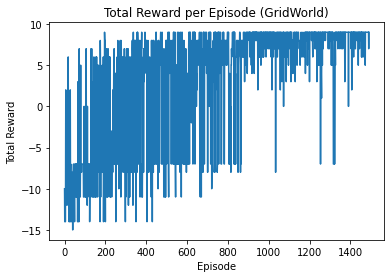

In [33]:
# plot the total reward per episode graph
plt.plot(dqn_gridworld_reward_history)
plt.title('Total Reward per Episode (GridWorld)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

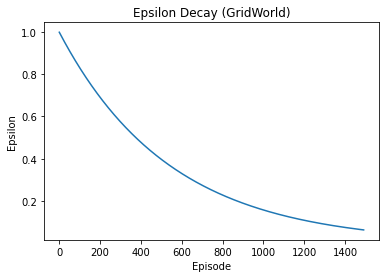

In [34]:
# plot the epsilon decay graph
plt.plot(dqn_gridworld_epsilon_history)
plt.title('Epsilon Decay (GridWorld)')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

In [35]:
# evaluate the agent
eval_reward_history = agent.evaluate(num_episodes=5, render=False)

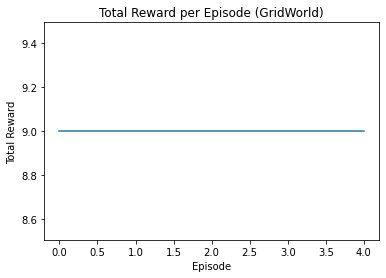

In [36]:
# plot the total reward per episode graph
plt.plot(eval_reward_history)
plt.title('Total Reward per Episode (GridWorld)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

### Performance Comparison of DQN and Double DQN

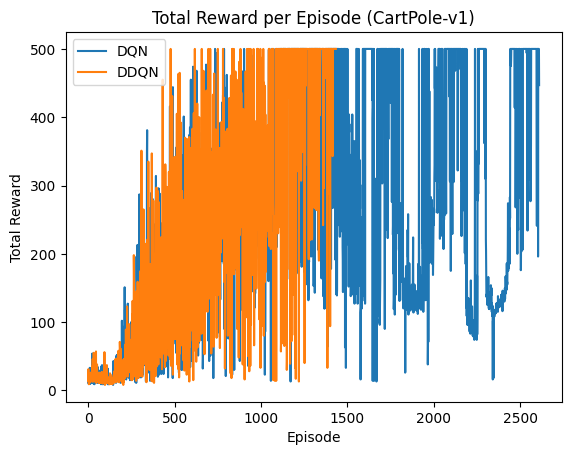

In [34]:
# load the pickle files for cartpole
with open('./weights/dqn_cartpole_reward_history.pkl', 'rb') as f:
    dqn_cartpole_reward_history = pickle.load(f)

with open('./weights/ddqn_cartpole_reward_history.pkl', 'rb') as f:
    ddqn_cartpole_reward_history = pickle.load(f)

# plot the total reward per episode graph
plt.plot(dqn_cartpole_reward_history, label='DQN')
plt.plot(ddqn_cartpole_reward_history, label='DDQN')
plt.title('Total Reward per Episode (CartPole-v1)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

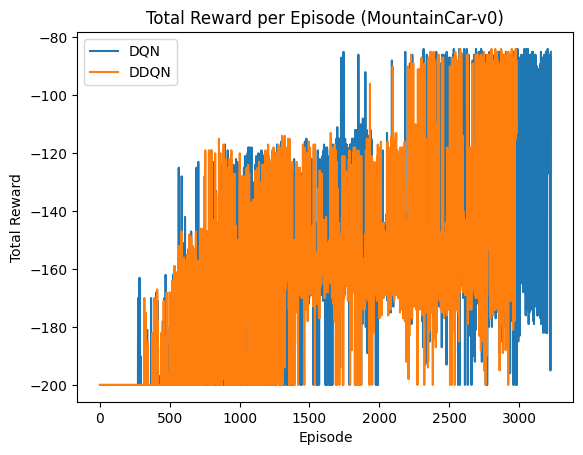

In [4]:
# load the pickle files for mountaincar
with open('./weights/dqn_mountaincar_reward_history.pkl', 'rb') as f:
    dqn_mountaincar_reward_history = pickle.load(f)

with open('./weights/ddqn_mountaincar_reward_history.pkl', 'rb') as f:
    ddqn_mountaincar_reward_history = pickle.load(f)

# plot the total reward per episode graph
plt.plot(dqn_mountaincar_reward_history, label='DQN')
plt.plot(ddqn_mountaincar_reward_history, label='DDQN')
plt.title('Total Reward per Episode (MountainCar-v0)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

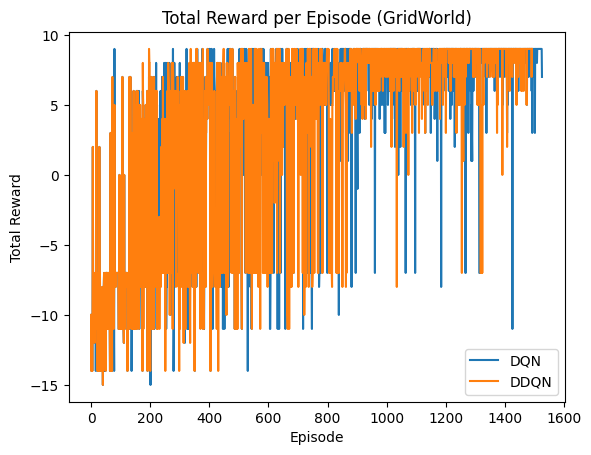

In [2]:
# load the pickle files for gridworld
with open('./weights/dqn_gridworld_reward_history.pkl', 'rb') as f:
    dqn_gridworld_reward_history = pickle.load(f)

with open('./weights/ddqn_gridworld_reward_history.pkl', 'rb') as f:
    ddqn_gridworld_reward_history = pickle.load(f)

# plot the total reward per episode graph
plt.plot(dqn_gridworld_reward_history, label='DQN')
plt.plot(ddqn_gridworld_reward_history, label='DDQN')
plt.title('Total Reward per Episode (GridWorld)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()